In [1]:
from IPython.display import HTML

<h1 style="background-color: darkred; color: white; font-size: 30px; border-radius: 20px; padding: 16px; text-align: center;"><b>🚘 Can I Sell my Car for a Good Price? </b></h1>

Hello. I'm happy to share my notebook designed as a guide for PS4E9.<br>
I hope this will be helpful to person who enjoy data like me.😁

# 

# 🍴 Table of Contents

- Goal & Metric of this Competition
- Description of Features
- Import Libraries & our Data
- Basic Data Exploration
- Feature Engineering
- Handling Missing Values & Rare Classes
- Visualizing EDA
- LGBM Modeling
- CATB Modelint (TBD)
- Ensemble (TBD)
- Prediction & Submission
- My Insights from our Data

# 

# 🥅 Goal & Metric of this Competition

1. The goal of this competition is to predict the price of used cars based on various attributes. <br>
2. The evaluation of this competition is Root Mean Squared Error (RMSE).

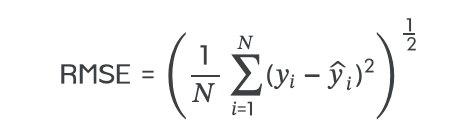

# 

# ✐ Description of Features

1. price : **[target]** the sale price of the used car

2. brand : manufacturer  ex) BMW, Audi, Chevrolet, etc.

3. model : name of the car ex) BMW 328i, Chevrolet Camaro 1LT, etc.

4. model_year : the actual production year of the car

5. milage : how far the car has been driven

6. fuel_type : ex) Gasoline, Hybrid, Electric, etc.

7. engine : the specifications of the car’s engine. ex) displacement, number of cylinders, and horsepower.

8. transmission : ex) Automatic (A/T), Manual (M/T), etc.

9. ext_col : exterior color of the car.

10. int_col : interior color of the car.

11. accident : whether the car has been involved in any accidents

12. clean_title : whether it has a clean title or not

# 

# 🚢 Import Libraies & our Data

In [2]:
#Basic
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from IPython.display import clear_output

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

#EDA
from wordcloud import WordCloud

#Feature Engineering
import re
from sklearn.impute import SimpleImputer

#Modeling
import lightgbm as lgb
from sklearn.model_selection import KFold, RandomizedSearchCV, train_test_split, cross_val_score
from random import random, randint, randrange, uniform
from lightgbm import LGBMRegressor
from lightgbm import log_evaluation, early_stopping
from catboost import CatBoostRegressor


#Model Evaluation
from sklearn.metrics import *
from sklearn.metrics import mean_squared_error

rs = 9

In [3]:
df_train = pd.read_csv('/kaggle/input/playground-series-s4e9/train.csv', index_col='id')
df_test = pd.read_csv('/kaggle/input/playground-series-s4e9/test.csv', index_col='id')
df_sub = pd.read_csv('/kaggle/input/playground-series-s4e9/sample_submission.csv')

# 

# 👀 Basic Data Exploration

In [4]:
print('The shape of train dataset is', df_train.shape)
print('The shape of test dataset is', df_test.shape , '\n')
print('The duplicate rows in the train dataset :', df_train.duplicated().sum() )
print('The duplicate rows in the test dataset :', df_test.duplicated().sum() , '\n')
print('>> The Descriptive Statistics of Train Data \n')
df_train.describe().T

The shape of train dataset is (188533, 12)
The shape of test dataset is (125690, 11) 

The duplicate rows in the train dataset : 0
The duplicate rows in the test dataset : 0 

>> The Descriptive Statistics of Train Data 



count          mean           std     min      25%      50%  \
model_year  188533.0   2015.829998      5.660967  1974.0   2013.0   2017.0   
milage      188533.0  65705.295174  49798.158076   100.0  24115.0  57785.0   
price       188533.0  43878.016178  78819.522254  2000.0  17000.0  30825.0   

                75%        max  
model_year   2020.0     2024.0  
milage      95400.0   405000.0  
price       49900.0  2954083.0

In [5]:
print('>> The Descriptive Statistics of Test Data \n')
df_test.describe().T

>> The Descriptive Statistics of Test Data 



count          mean           std     min      25%      50%  \
model_year  125690.0   2015.797526      5.673797  1974.0   2013.0   2017.0   
milage      125690.0  66042.581510  50223.858435   100.0  24500.0  57500.0   

                75%       max  
model_year   2020.0    2024.0  
milage      95798.0  405000.0

<h1 style="font-size: 14px; border-radius: 15px; padding: 12px; border: 4px solid darkred; line-height: 1.4;">
Grouping Features (Numerical Features vs Categorical Features)</h1>

In [6]:
print('>> The data type of each columns \n')
df_train.info()

>> The data type of each columns 

<class 'pandas.core.frame.DataFrame'>
Index: 188533 entries, 0 to 188532
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   brand         188533 non-null  object
 1   model         188533 non-null  object
 2   model_year    188533 non-null  int64 
 3   milage        188533 non-null  int64 
 4   fuel_type     183450 non-null  object
 5   engine        188533 non-null  object
 6   transmission  188533 non-null  object
 7   ext_col       188533 non-null  object
 8   int_col       188533 non-null  object
 9   accident      186081 non-null  object
 10  clean_title   167114 non-null  object
 11  price         188533 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 18.7+ MB


<h1 style="font-size: 14px; border-radius: 15px; padding: 12px; border: 4px solid darkred; line-height: 1.4;">
We will categorize the features into numerical and categorical types for further analysis.  </h1>

In [7]:
features = ['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
target = 'price'
num_features = ['milage']
cat_features = ['model_year', 'clean_title', 'accident', 'model', 'transmission', 'engine', 'ext_col', 'fuel_type', 'int_col', 'brand']

print('>> Numerical Features \n', num_features, '\n')
print('>> Categorical Features \n', cat_features, '\n')

>> Numerical Features 
 ['milage'] 

>> Categorical Features 
 ['model_year', 'clean_title', 'accident', 'model', 'transmission', 'engine', 'ext_col', 'fuel_type', 'int_col', 'brand'] 



In [8]:
print('>> Head 5 \n\n')
df_train.head()

>> Head 5 




brand              model  model_year  milage      fuel_type  \
id                                                                        
0            MINI      Cooper S Base        2007  213000       Gasoline   
1         Lincoln              LS V8        2002  143250       Gasoline   
2       Chevrolet  Silverado 2500 LT        2002  136731  E85 Flex Fuel   
3         Genesis   G90 5.0 Ultimate        2017   19500       Gasoline   
4   Mercedes-Benz        Metris Base        2021    7388       Gasoline   

                                               engine  \
id                                                      
0        172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel   
1        252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel   
2   320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...   
3        420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel   
4        208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   

                      transmission ext_col int_col  \
id                                                   
0                              A/T  Yellow    Gray   
1                              A/T  Silver   Beige   
2                              A/T    Blue    Gray   
3   Transmission w/Dual Shift Mode   Black   Black   
4                      7-Speed A/T   Black   Beige   

                                  accident clean_title  price  
id                                                             
0                            None reported         Yes   4200  
1   At least 1 accident or damage reported         Yes   4999  
2                            None reported         Yes  13900  
3                            None reported         Yes  45000  
4                            None reported         Yes  97500

In [9]:
print('>> Tail 5 \n\n')
df_train.tail()

>> Tail 5 




brand                     model  model_year  milage fuel_type  \
id                                                                              
188528       Cadillac     Escalade ESV Platinum        2017   49000  Gasoline   
188529  Mercedes-Benz  AMG C 43 AMG C 43 4MATIC        2018   28600  Gasoline   
188530  Mercedes-Benz    AMG GLC 63 Base 4MATIC        2021   13650  Gasoline   
188531           Audi          S5 3.0T Prestige        2022   13895  Gasoline   
188532        Porsche                Macan Base        2016   59500  Gasoline   

                                               engine  \
id                                                      
188528   420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel   
188529  385.0HP 3.0L V6 Cylinder Engine Gasoline Fuel   
188530   469.0HP 4.0L 8 Cylinder Engine Gasoline Fuel   
188531                                           3.0L   
188532   252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   

                          transmission                    ext_col int_col  \
id                                                                          
188528  Transmission w/Dual Shift Mode                      White   Beige   
188529                     8-Speed A/T                      White   Black   
188530                     7-Speed A/T                      White   Black   
188531               1-Speed Automatic  Daytona Gray Pearl Effect   Black   
188532  Transmission w/Dual Shift Mode                      White   Black   

                                      accident clean_title  price  
id                                                                 
188528                           None reported         Yes  27500  
188529  At least 1 accident or damage reported         Yes  30000  
188530                           None reported         Yes  86900  
188531                           None reported         NaN  84900  
188532                           None reported         Yes  28995

<h1 style="font-size: 14px; border-radius: 20px; padding: 12px; border: 4px solid darkred; line-height: 1.6;">
We can see that the 'engine' feature contains valuable information. I will now proceed with feature extraction. The idea and code were inspired by Dinesh. <a href="https://www.kaggle.com/competitions/playground-series-s4e9/discussion/531434 target="_blank""> Click here to view Dinesh's idea and code.</a></h1>

# 

# 🦫 Feature Engineering

<h1 style="font-size: 14px; border-radius: 20px; padding: 12px; border: 4px solid darkred; line-height: 1.6;">
Also we can create new features that represent the vehicle's age and the annual mileage. <br></br>
Let's check the columns in the DataFrame after feature engineering.
Here are the new columns: engine_hp, engine_cc, engine_cyl, engine_turbo, engine_flexfuel, engine_hybrid, electric, vehicle_age, and mileage_per_year.</h1>

In [10]:
def decode_engine(s:str):
    s = s.lower()

    hpgroup = re.match(r'(\d+(\.\d+)?\s*)hp', s )
    engine_hp = float(hpgroup.group(1)) if hpgroup else ''

    ccgroup = re.search(r'(\d+(\.\d+)?\s*)l', s )
    engine_cc = float(ccgroup.group(1)) if ccgroup else ''

    cylindergroup = re.search(r'(\d+(\.\d+)?\s*)cylinder', s )
    engine_cyl = int(cylindergroup.group(1)) if cylindergroup else ''

    turbogroup = re.search(r'turbo', s)
    turbo = True if turbogroup else False

    flexgroup = re.search(r'flex fuel|flex', s)
    flex_fuel = True if flexgroup else False

    hybridgroup = re.search(r'hybrid', s)
    hybrid = True if hybridgroup else False

    electricgroup = re.search(r'electric', s)
    electric = True if electricgroup else False

    
    return engine_hp,engine_cc,engine_cyl, turbo, flex_fuel, hybrid,electric

df_train[['engine_hp','engine_cc','engine_cyl','engine_turbo','engine_flexfuel','engine_hybrid','electric']]=df_train['engine'].apply(decode_engine).apply(pd.Series)
df_test[['engine_hp','engine_cc','engine_cyl','engine_turbo','engine_flexfuel','engine_hybrid','electric']]=df_test['engine'].apply(decode_engine).apply(pd.Series)

In [11]:
from datetime import datetime

def create_features(df):
    
    current_year = datetime.now().year

    df['vehicle_age'] = current_year - df['model_year']

    df['mileage_per_year'] = df['milage'] / df['vehicle_age']
    
create_features(df_train)
create_features(df_test)

In [12]:
df_train = df_train.drop('engine', axis=1)
df_test = df_test.drop('engine', axis=1)
df_train

brand                     model  model_year  milage  \
id                                                                    
0                MINI             Cooper S Base        2007  213000   
1             Lincoln                     LS V8        2002  143250   
2           Chevrolet         Silverado 2500 LT        2002  136731   
3             Genesis          G90 5.0 Ultimate        2017   19500   
4       Mercedes-Benz               Metris Base        2021    7388   
...               ...                       ...         ...     ...   
188528       Cadillac     Escalade ESV Platinum        2017   49000   
188529  Mercedes-Benz  AMG C 43 AMG C 43 4MATIC        2018   28600   
188530  Mercedes-Benz    AMG GLC 63 Base 4MATIC        2021   13650   
188531           Audi          S5 3.0T Prestige        2022   13895   
188532        Porsche                Macan Base        2016   59500   

            fuel_type                    transmission  \
id                                                      
0            Gasoline                             A/T   
1            Gasoline                             A/T   
2       E85 Flex Fuel                             A/T   
3            Gasoline  Transmission w/Dual Shift Mode   
4            Gasoline                     7-Speed A/T   
...               ...                             ...   
188528       Gasoline  Transmission w/Dual Shift Mode   
188529       Gasoline                     8-Speed A/T   
188530       Gasoline                     7-Speed A/T   
188531       Gasoline               1-Speed Automatic   
188532       Gasoline  Transmission w/Dual Shift Mode   

                          ext_col int_col  \
id                                          
0                          Yellow    Gray   
1                          Silver   Beige   
2                            Blue    Gray   
3                           Black   Black   
4                           Black   Beige   
...                           ...     ...   
188528                      White   Beige   
188529                      White   Black   
188530                      White   Black   
188531  Daytona Gray Pearl Effect   Black   
188532                      White   Black   

                                      accident clean_title  price engine_hp  \
id                                                                            
0                                None reported         Yes   4200     172.0   
1       At least 1 accident or damage reported         Yes   4999     252.0   
2                                None reported         Yes  13900     320.0   
3                                None reported         Yes  45000     420.0   
4                                None reported         Yes  97500     208.0   
...                                        ...         ...    ...       ...   
188528                           None reported         Yes  27500     420.0   
188529  At least 1 accident or damage reported         Yes  30000     385.0   
188530                           None reported         Yes  86900     469.0   
188531                           None reported         NaN  84900             
188532                           None reported         Yes  28995     252.0   

       engine_cc engine_cyl  engine_turbo  engine_flexfuel  engine_hybrid  \
id                                                                          
0            1.6          4         False            False          False   
1            3.9          8         False            False          False   
2            5.3          8         False             True          False   
3            5.0          8         False            False          False   
4            2.0          4         False            False          False   
...          ...        ...           ...              ...            ...   
188528       6.2          8         False            False          False   
188529       3.0          6         False  

# 

# ✋🏼 Handling Missing Values & Rare Classes

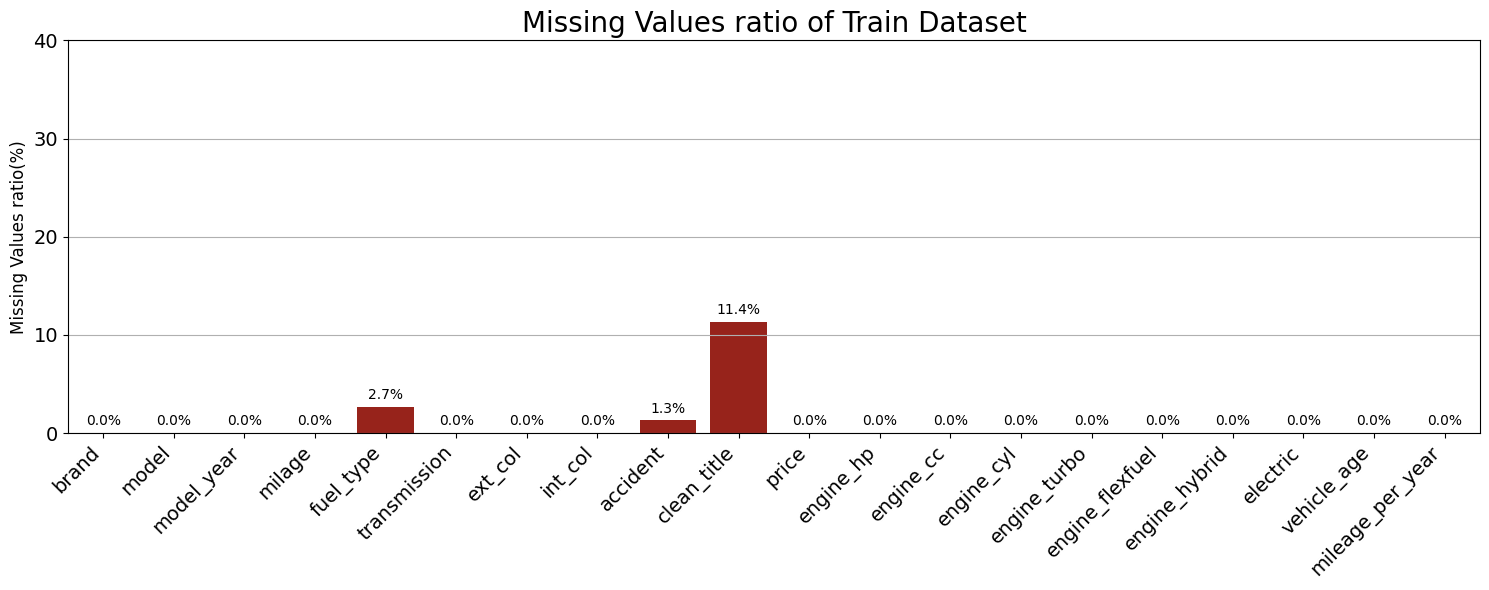

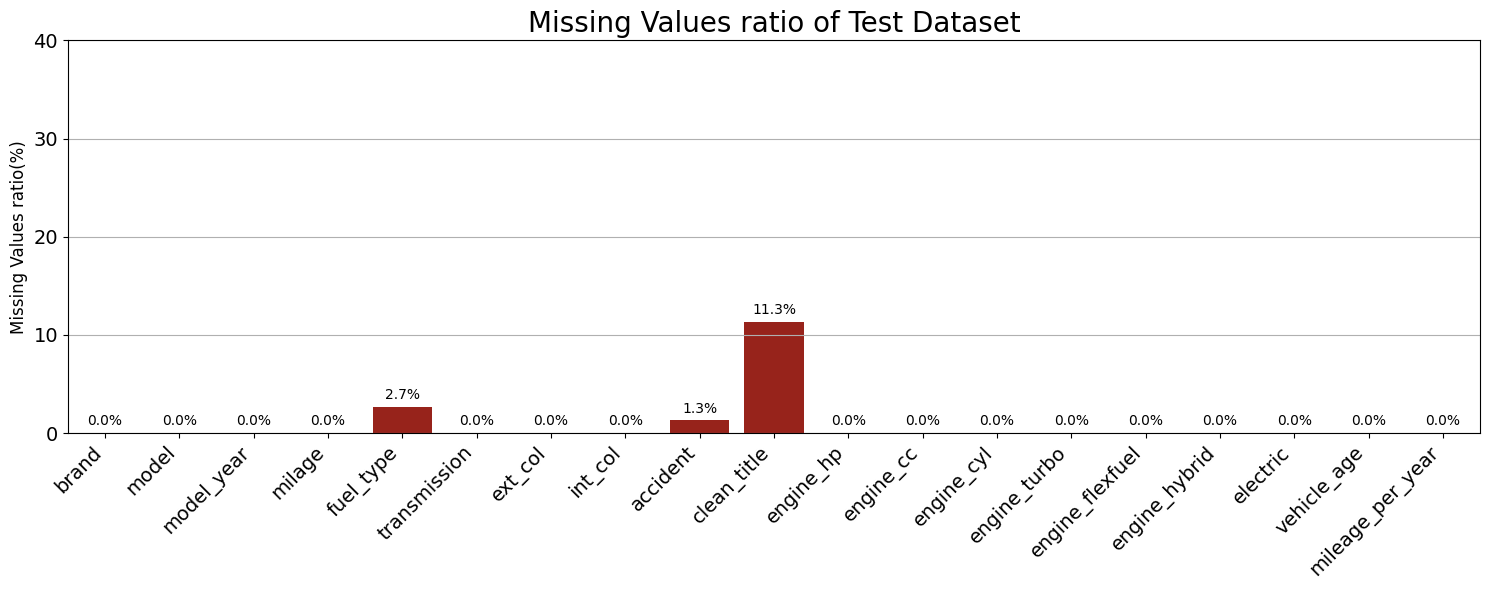

In [13]:
def plot_missing_values(df, title, color):
    missing_ratio = df.isnull().sum() / len(df) * 100
    missing_df = pd.DataFrame({'column': missing_ratio.index, 'missing_ratio': missing_ratio.values})
    
    plt.figure(figsize=(15, 6))
    plt.grid(True)
    ax = sns.barplot(x='column', y='missing_ratio', data=missing_df, color=color)
    
    plt.xticks(rotation=45, ha='right', fontsize = 14)
    plt.xlabel('')
    
    plt.title(title, fontsize = 20)
    
    plt.yticks(range(0, 41, 10), fontsize = 14)
    plt.ylabel('Missing Values ratio(%)', fontsize = 12)
    
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2.,
                height + 0.8,
                '{:.1f}%'.format(height),
                ha="center")
    
    plt.tight_layout()
    plt.show()
    

plot_missing_values(df_train, 'Missing Values ratio of Train Dataset', '#ac1106')
plot_missing_values(df_test, 'Missing Values ratio of Test Dataset', '#ac1106')

<h1 style="font-size: 20px; border-radius: 20px; padding: 12px; border: 4px solid darkred; line-height: 1.6;">
Handling Missing Values 
</h1>

<h1 style="font-size: 14px; border-radius: 20px; padding: 12px; border: 4px solid darkred; line-height: 1.6;">
The missing values in 'fuel_type' are likely due to human error, whereas the missing values in 'accident' and 'clean_title' seem to be intentional omissions by the respondents.
<br></br>
The respondents may have intentionally chosen not to answer the survey in order to hide the fact that they do not have a clean title or have a history of accidents.
<br></br>
Therefore, I'll use the Imputer function to fill in the missing values in 'fuel_type' with the most frequent value, and I'll label the missing values in 'accident' and 'clean_title' as 'missing.'</h1>

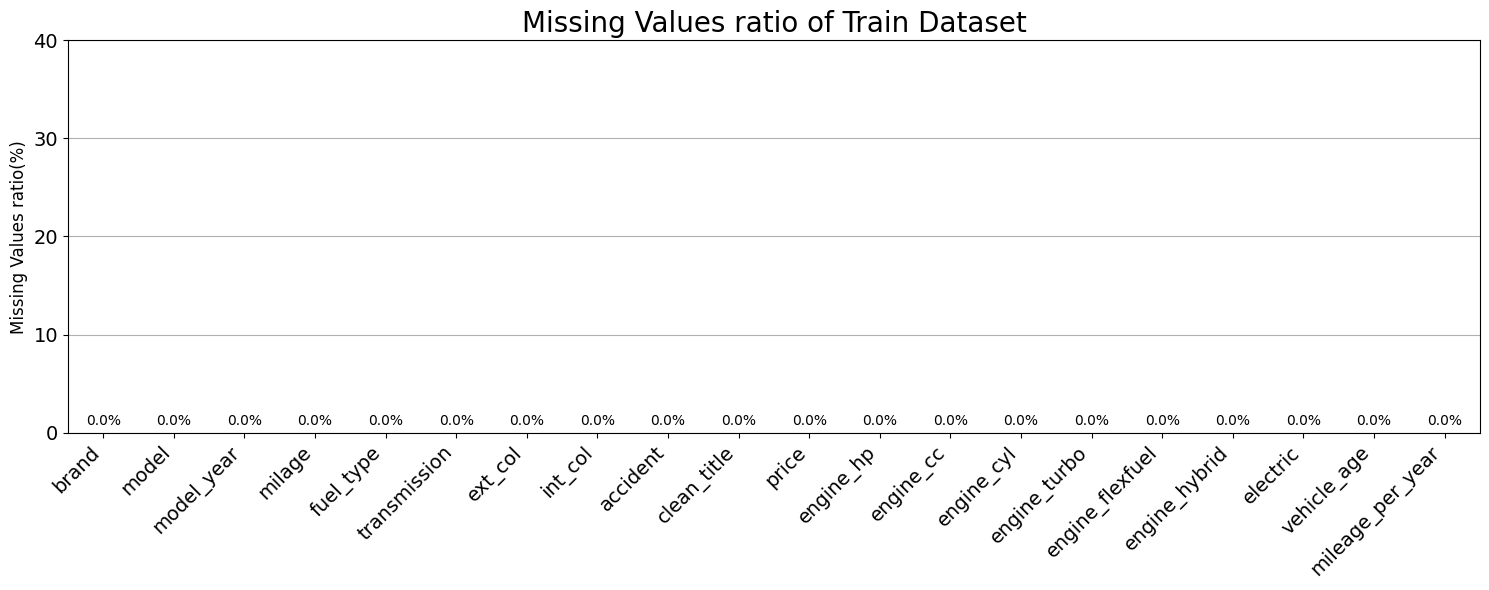

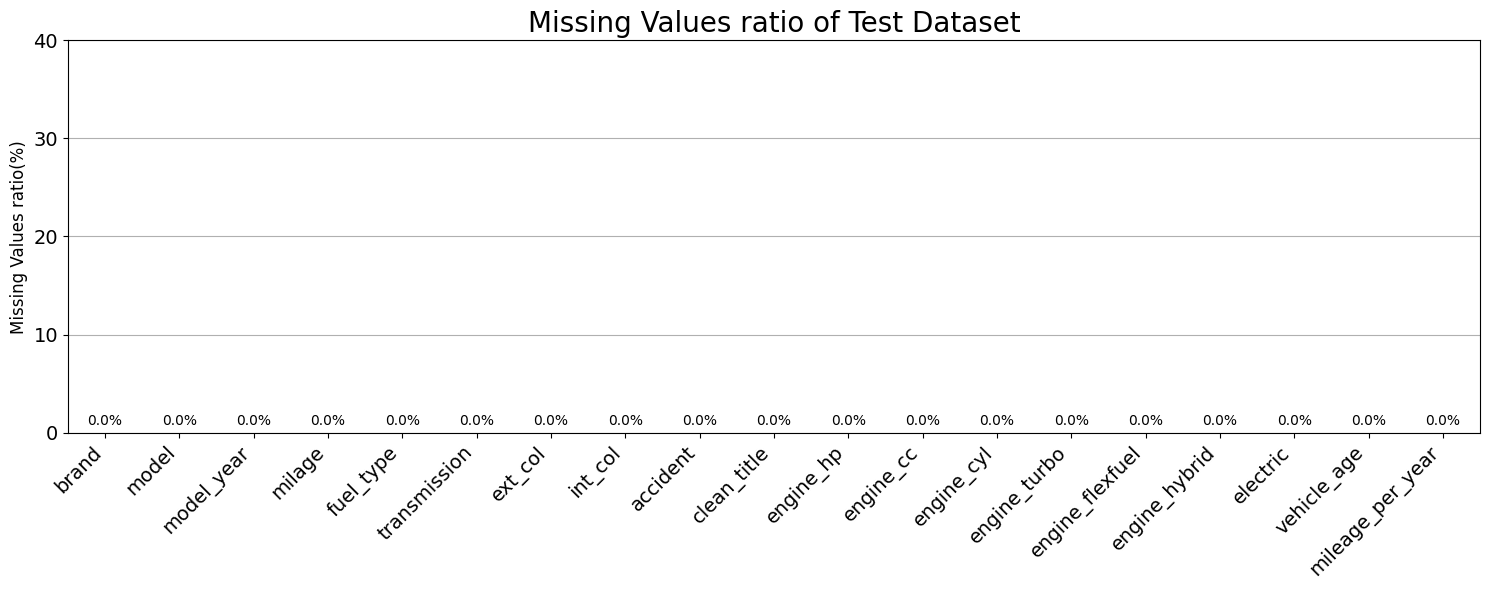

In [14]:
def cleaning_data(df):

    fuel_type_imputer = SimpleImputer(strategy='most_frequent')
    df['fuel_type'] = fuel_type_imputer.fit_transform(df[['fuel_type']]).ravel() 
    
    missing_label_imputer = SimpleImputer(strategy='constant', fill_value='missing')
    df[['accident', 'clean_title']] = missing_label_imputer.fit_transform(df[['accident', 'clean_title']])
    
    return df

df_train_cleaned = cleaning_data(df_train)
df_test_cleaned = cleaning_data(df_test)

plot_missing_values(df_train_cleaned, 'Missing Values ratio of Train Dataset', '#00FF7F')
plot_missing_values(df_test_cleaned, 'Missing Values ratio of Test Dataset', '#00BFFF')

<h1 style="font-size: 20px; border-radius: 20px; padding: 12px; border: 4px solid darkred; line-height: 1.6;">
Handling Rare Classes</h1>

In [15]:
print('>> Checking Rare Classes \n')
print(df_train_cleaned['model'].value_counts(), '\n\n')
print(df_train_cleaned['brand'].value_counts())

>> Checking Rare Classes 

model
F-150 XLT                        2945
M3 Base                          2229
Camaro 2SS                       1709
M4 Base                          1622
Mustang GT Premium               1526
                                 ... 
ForTwo Pure                         2
X5 xDrive40e                        1
XLR Base                            1
X5 3.0i                             1
Integra w/A-Spec Tech Package       1
Name: count, Length: 1897, dtype: int64 


brand
Ford             23088
Mercedes-Benz    19172
BMW              17028
Chevrolet        16335
Audi             10887
Porsche          10612
Land              9525
Toyota            8850
Lexus             8643
Jeep              6474
Cadillac          4674
RAM               4249
Nissan            3930
Tesla             3738
INFINITI          3276
GMC               3215
Dodge             3133
Mazda             2719
Kia               2497
Lincoln           2423
Subaru            2381
Acura            

<h1 style="font-size: 14px; border-radius: 20px; padding: 12px; border: 4px solid darkred; line-height: 1.6;">
It seems that we can classify labels with fewer than 10 values as 'noise,' as they are considered rare classes.</h1>

In [16]:
quick_features = ['brand', 'model', 'fuel_type', 'transmission', 'ext_col', 'int_col']


def handling_rare(df):
    
    t = 10
    
    for col in quick_features:
        df.loc[df[col].value_counts(dropna=False)[df[col]].values < t, col] = "noise"
        
handling_rare(df_train_cleaned)
handling_rare(df_test_cleaned)

for col in quick_features:
    noise_count = df_train_cleaned[df_train_cleaned[col] == 'noise'].shape[0]
    print(f"The number of 'noise' | in the '{col}' column | {noise_count}")

The number of 'noise' | in the 'brand' column | 35
The number of 'noise' | in the 'model' column | 830
The number of 'noise' | in the 'fuel_type' column | 0
The number of 'noise' | in the 'transmission' column | 13
The number of 'noise' | in the 'ext_col' column | 213
The number of 'noise' | in the 'int_col' column | 70


# 

# 📈 Visualizing EDA

<h1 style="font-size: 20px; border-radius: 20px; padding: 12px; border: 4px solid darkred; line-height: 1.6;"> Target Distribution</h1>

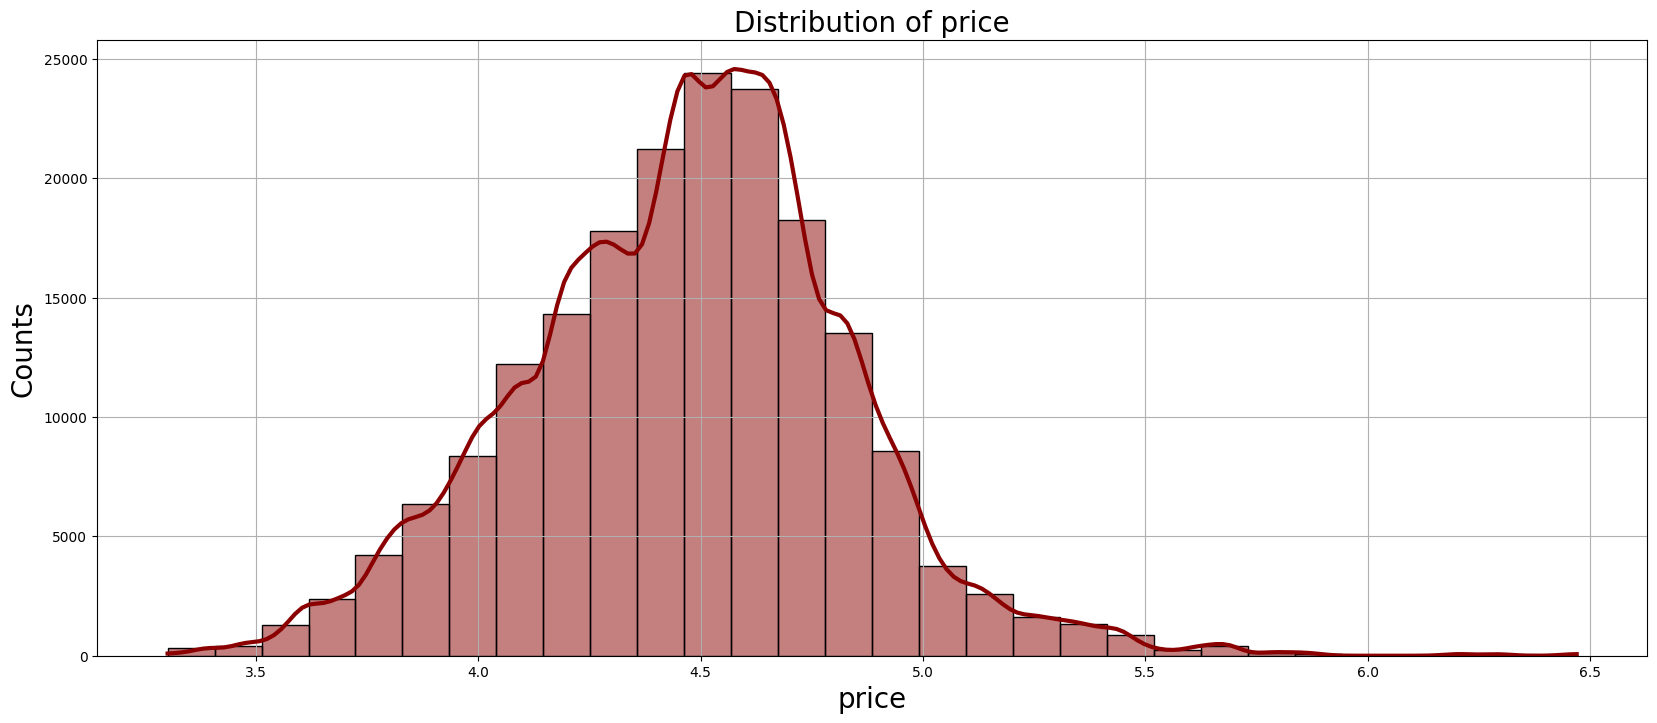

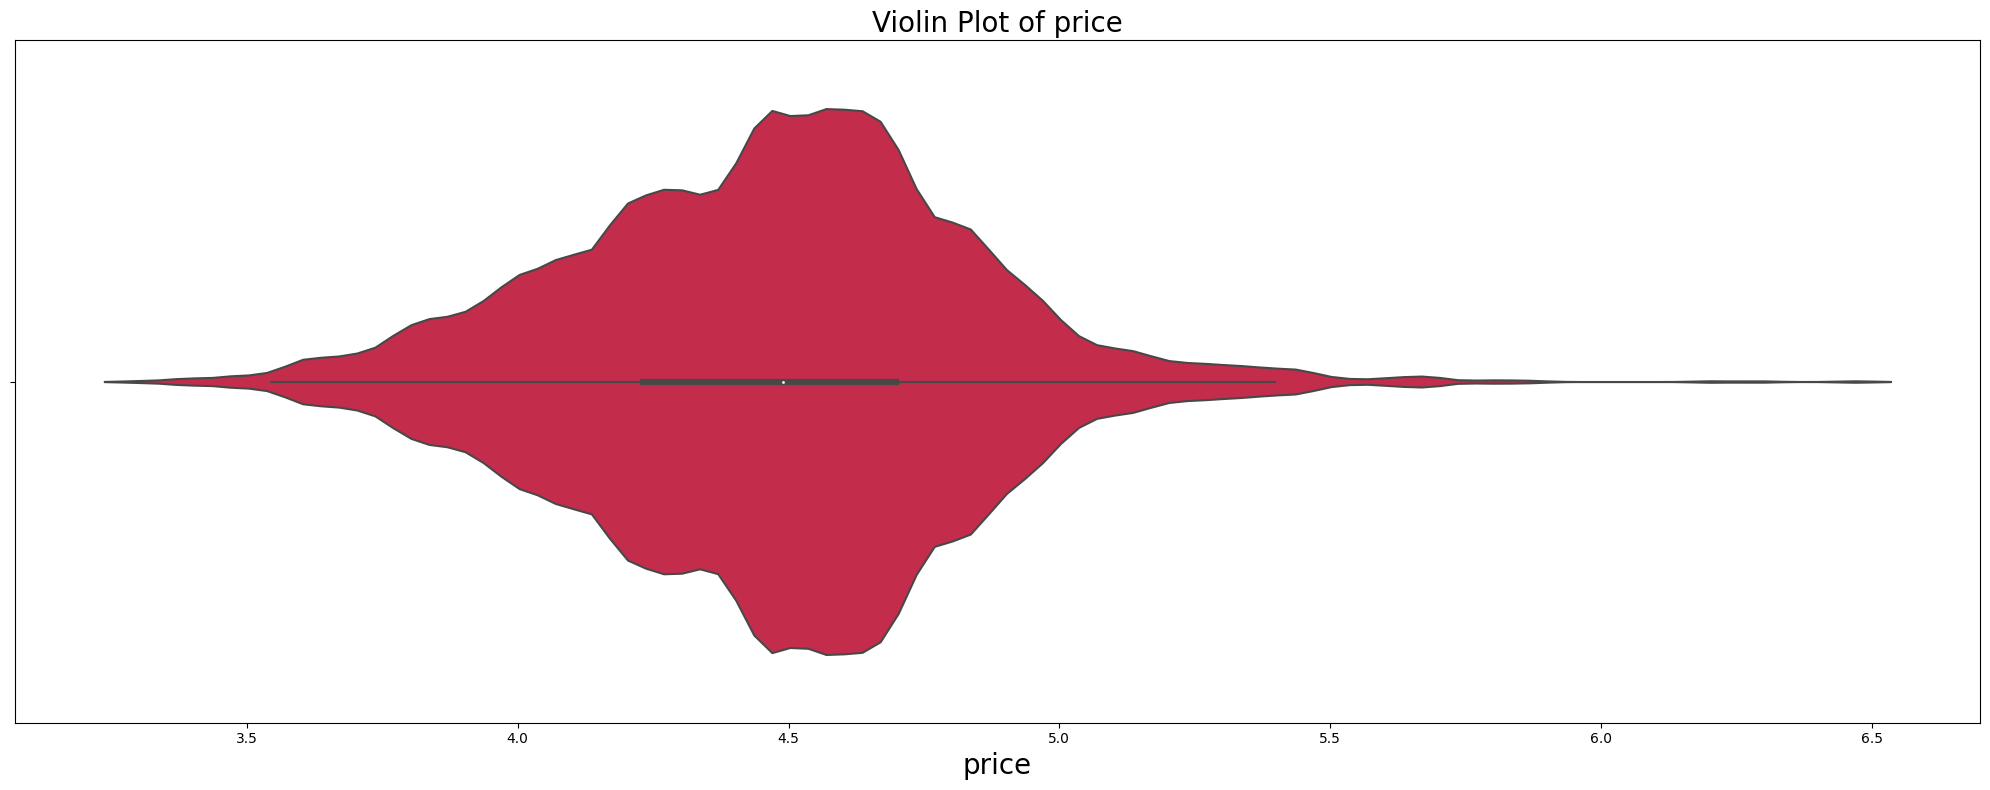

In [17]:
def plot_num_distribution(df, target_column):

    plt.figure(figsize=(20, 8))
    
    sns.histplot(
        np.log10(df[target_column]), 
        stat='count',
        kde=True, 
        bins=30, 
        color='darkred',
        line_kws = {'lw':3})
    
    plt.title(f'Distribution of {target_column}', fontsize=20)
    plt.xlabel(target_column, fontsize=20)
    plt.ylabel('Counts', fontsize=20)
    plt.grid(True)
    plt.show()
    
    
def plot_outlier_detection(df, target_column):

    plt.figure(figsize=(20, 8))
    
    sns.violinplot(x=np.log10(df[target_column]), color='crimson')
    plt.title(f'Violin Plot of {target_column}', fontsize=20)
    plt.xlabel(target_column, fontsize=20)
    
    plt.tight_layout()
    plt.show()
    
plot_num_distribution(df_train_cleaned, 'price')
plot_outlier_detection(df_train_cleaned, 'price')

<h1 style="font-size: 20px; border-radius: 20px; padding: 12px; border: 4px solid darkred; line-height: 1.6;"> Numerical Features Distribution</h1>

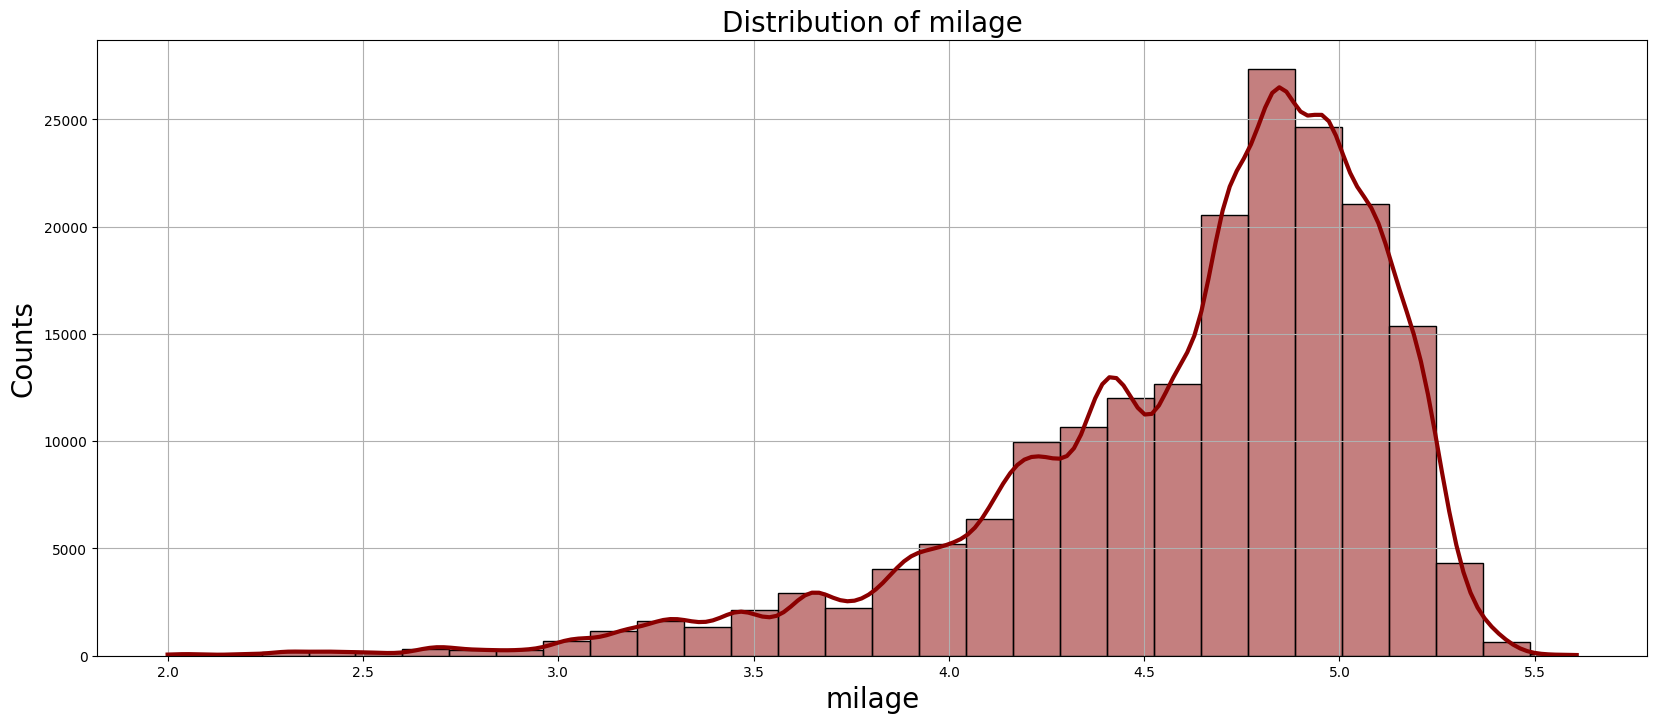

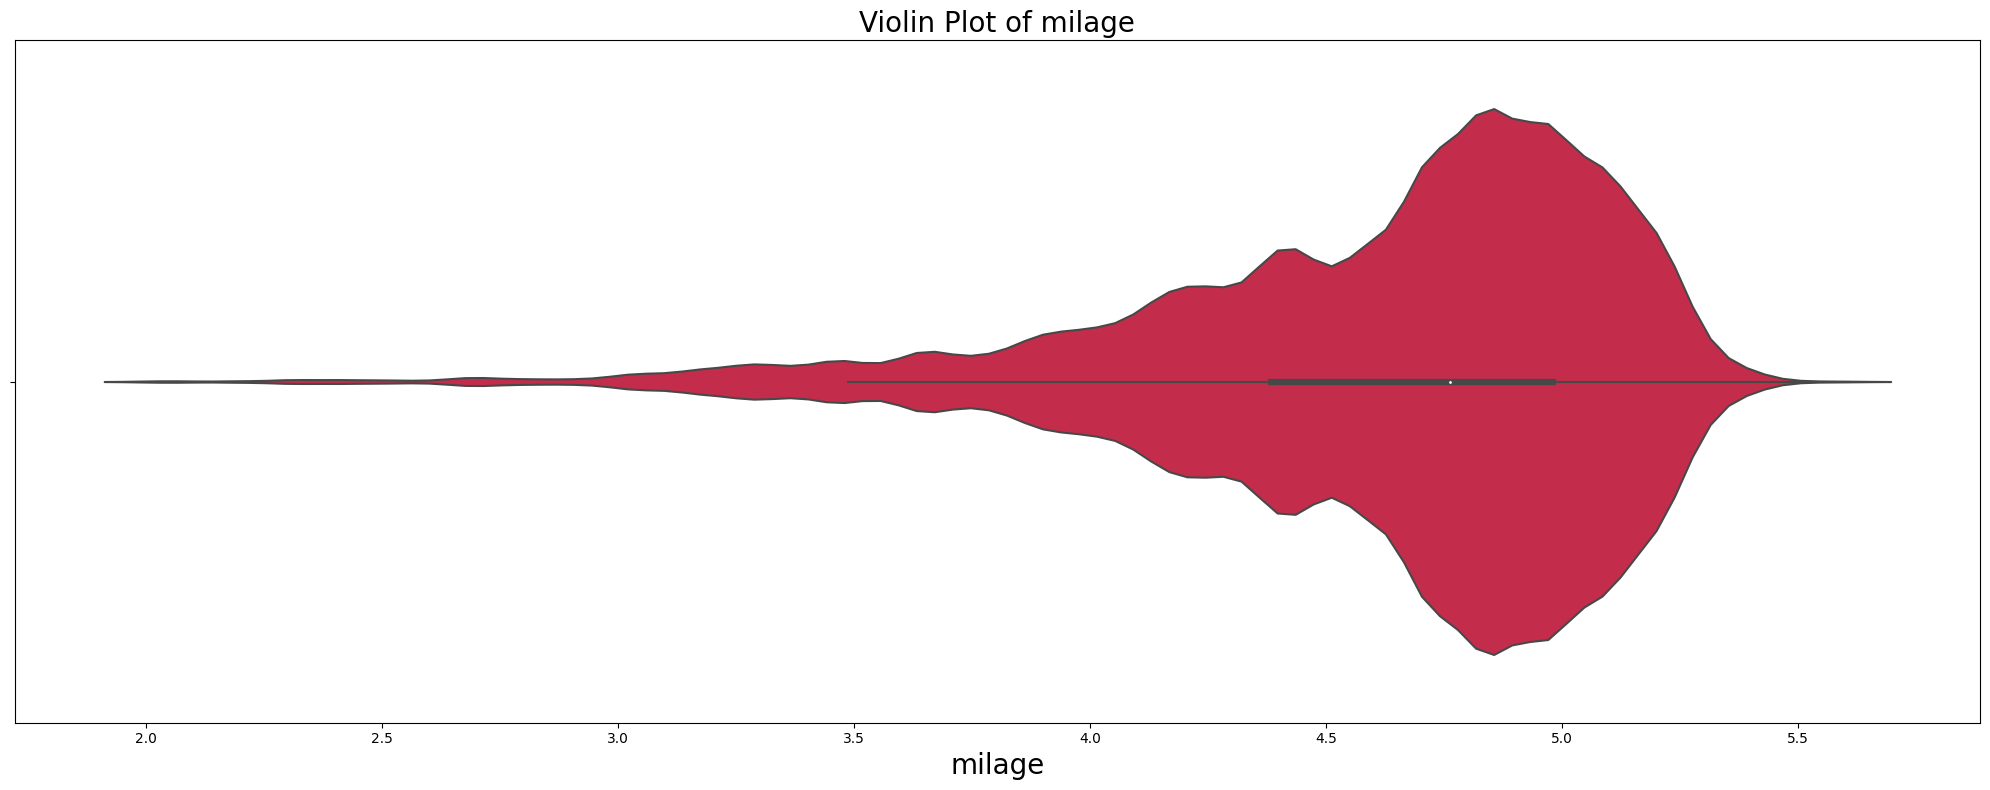

In [18]:
plot_num_distribution(df_train_cleaned, 'milage')
plot_outlier_detection(df_train_cleaned, 'milage')

<h1 style="font-size: 20px; border-radius: 20px; padding: 12px; border: 4px solid darkred; line-height: 1.6;">Categorical Features Distribution</h1>

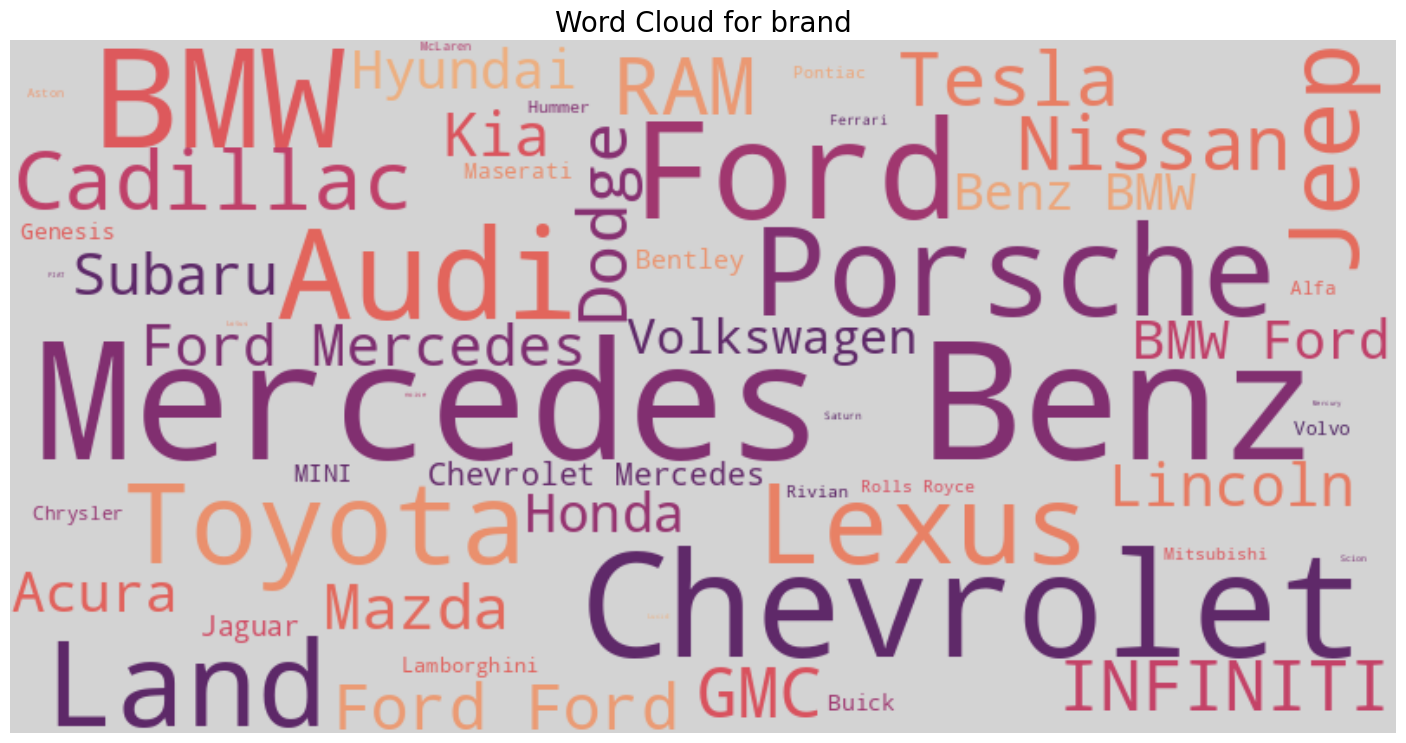

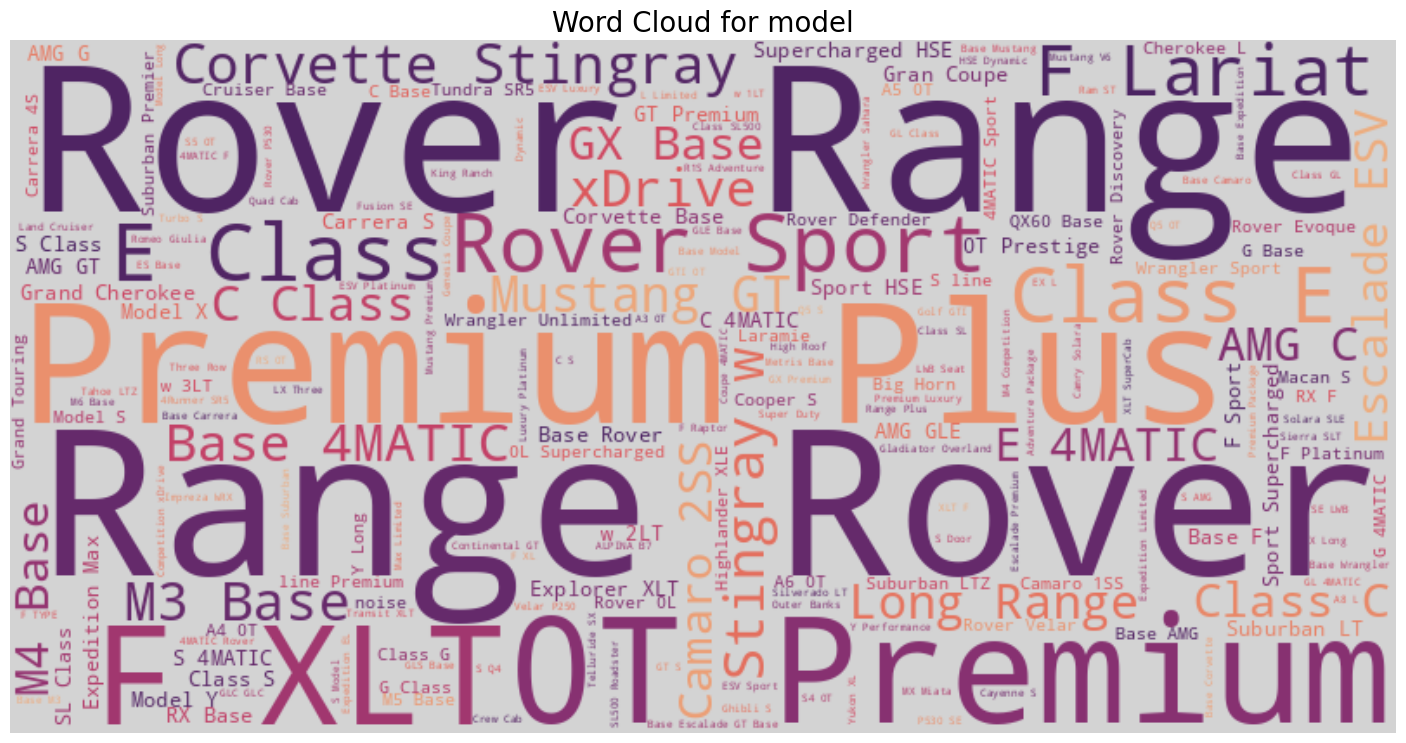

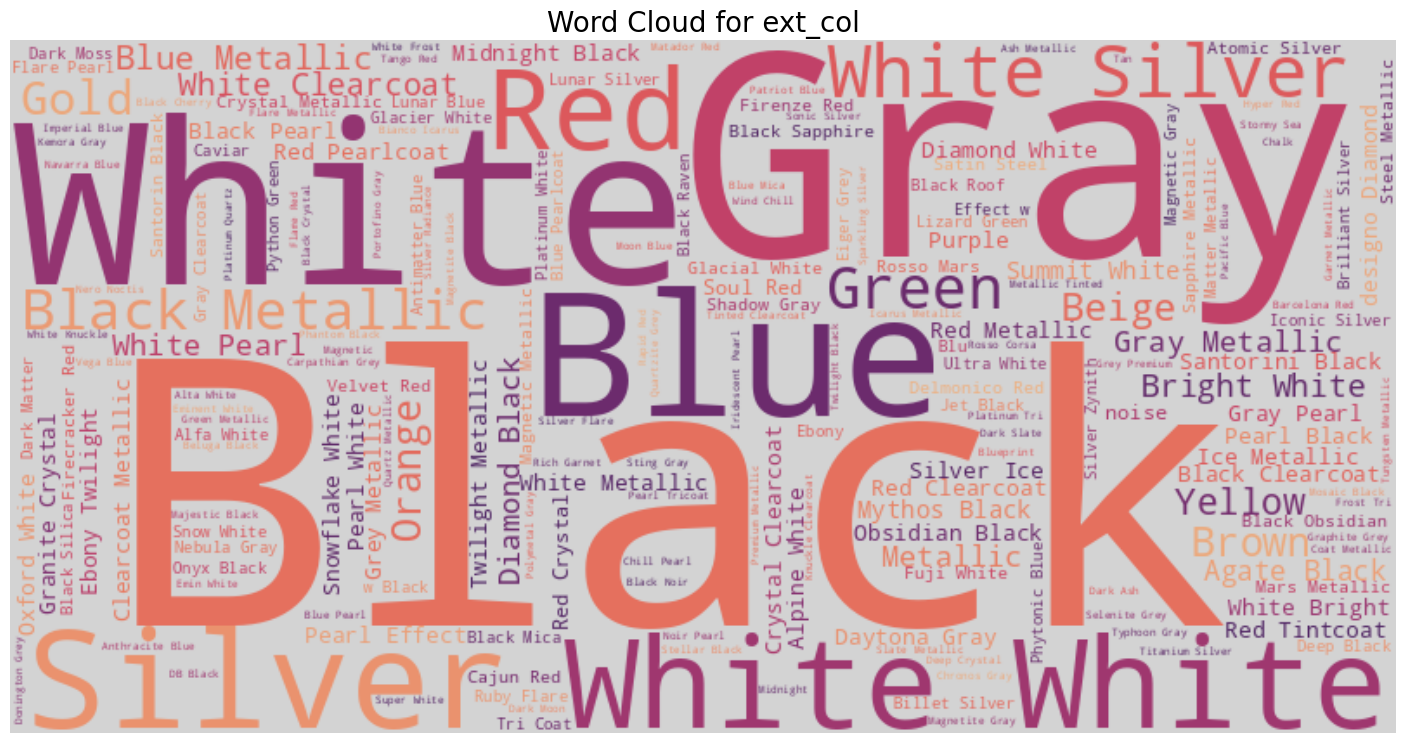

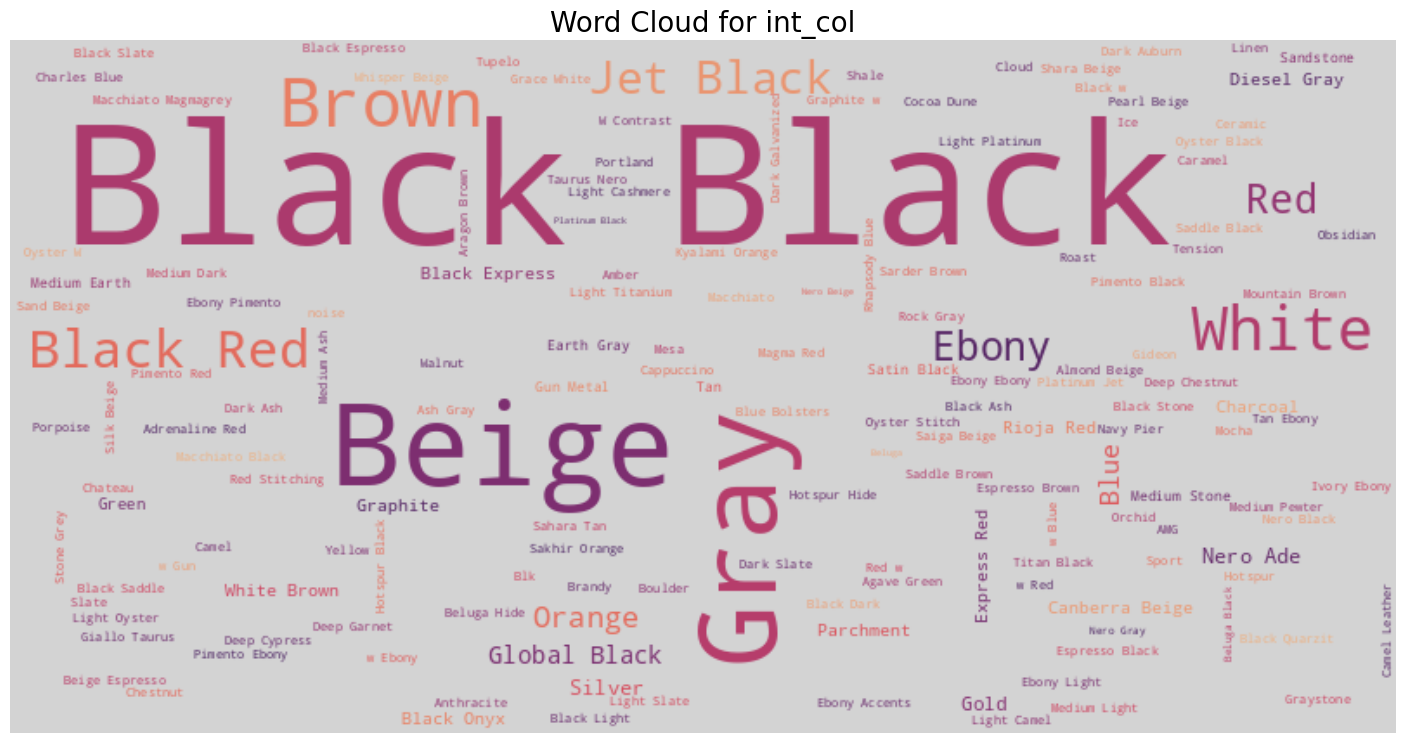

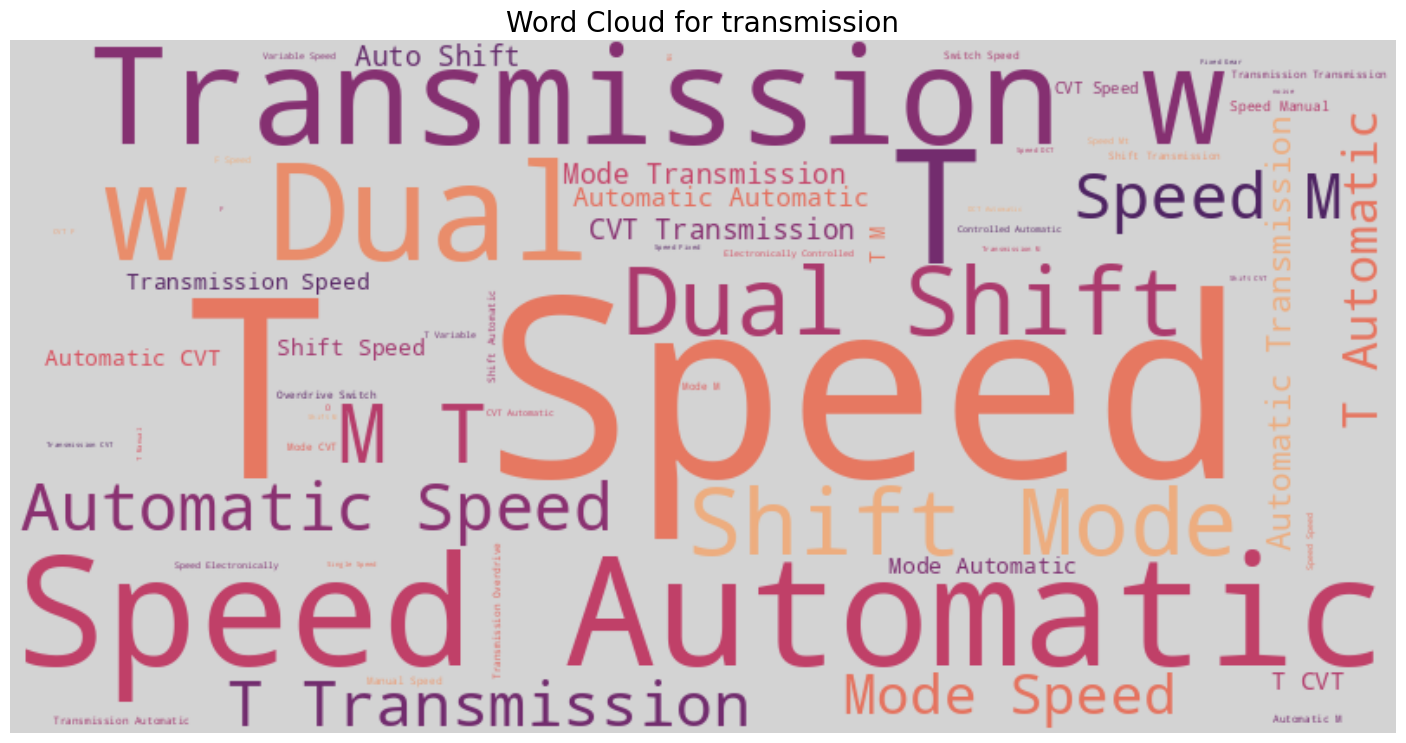

In [19]:
cat_features_word = ['brand', 'model', 'ext_col', 'int_col', 'transmission']
palettes = 'flare'

for feature in cat_features_word:
    text = ' '.join(df_train_cleaned[feature].astype(str).values)
    
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='lightgray',
        colormap = palettes).generate(text)
    
    plt.figure(figsize=(20, 9))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {feature}', fontsize=20)
    plt.subplots_adjust(hspace=3) 
    plt.show()

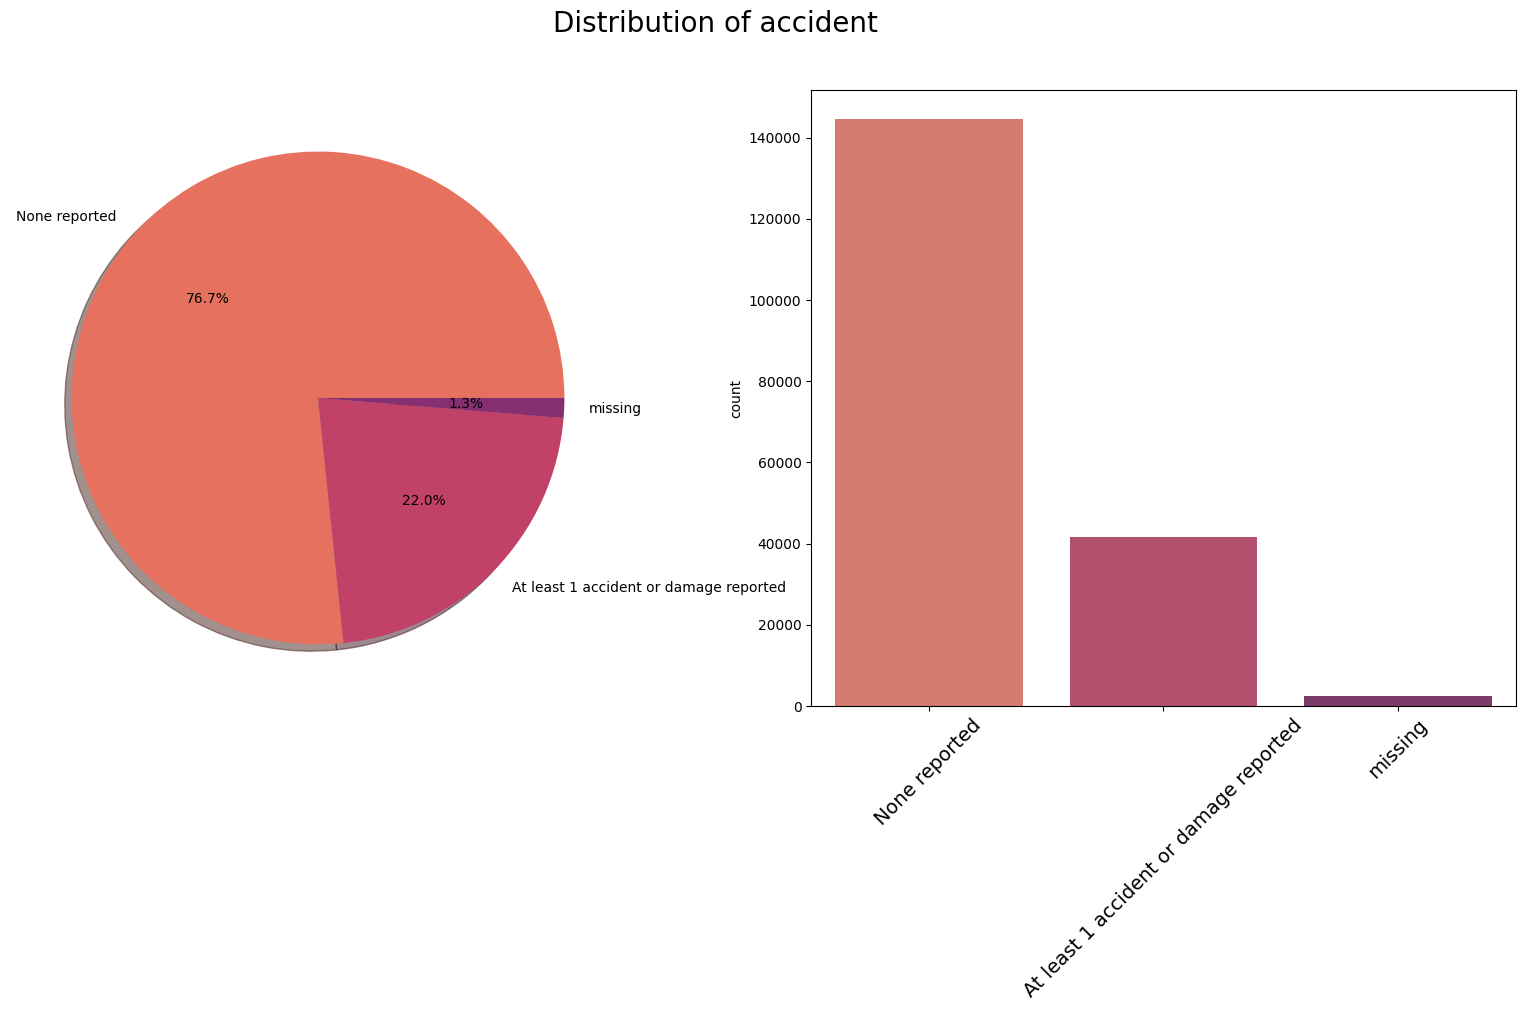

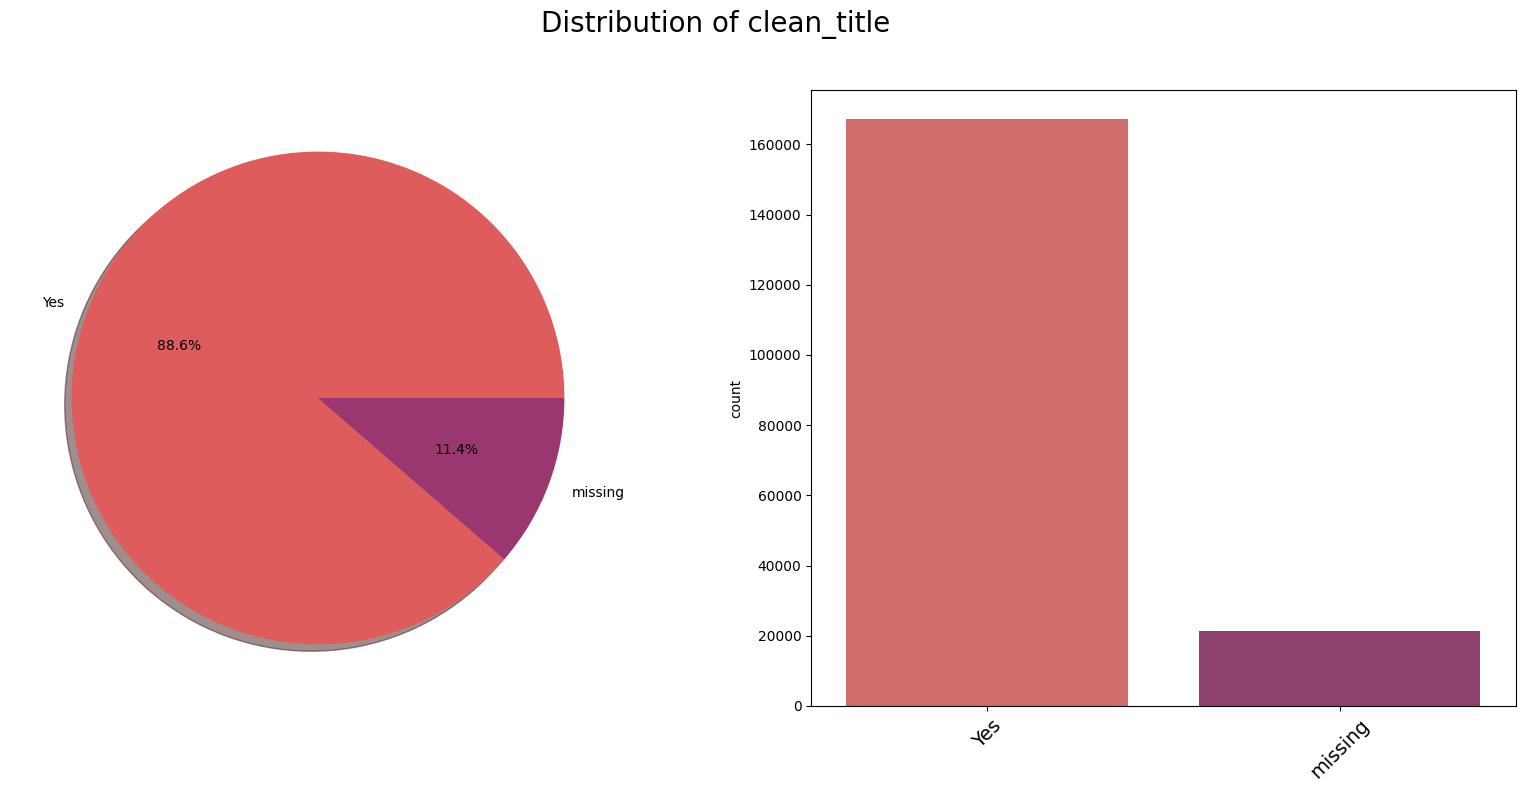

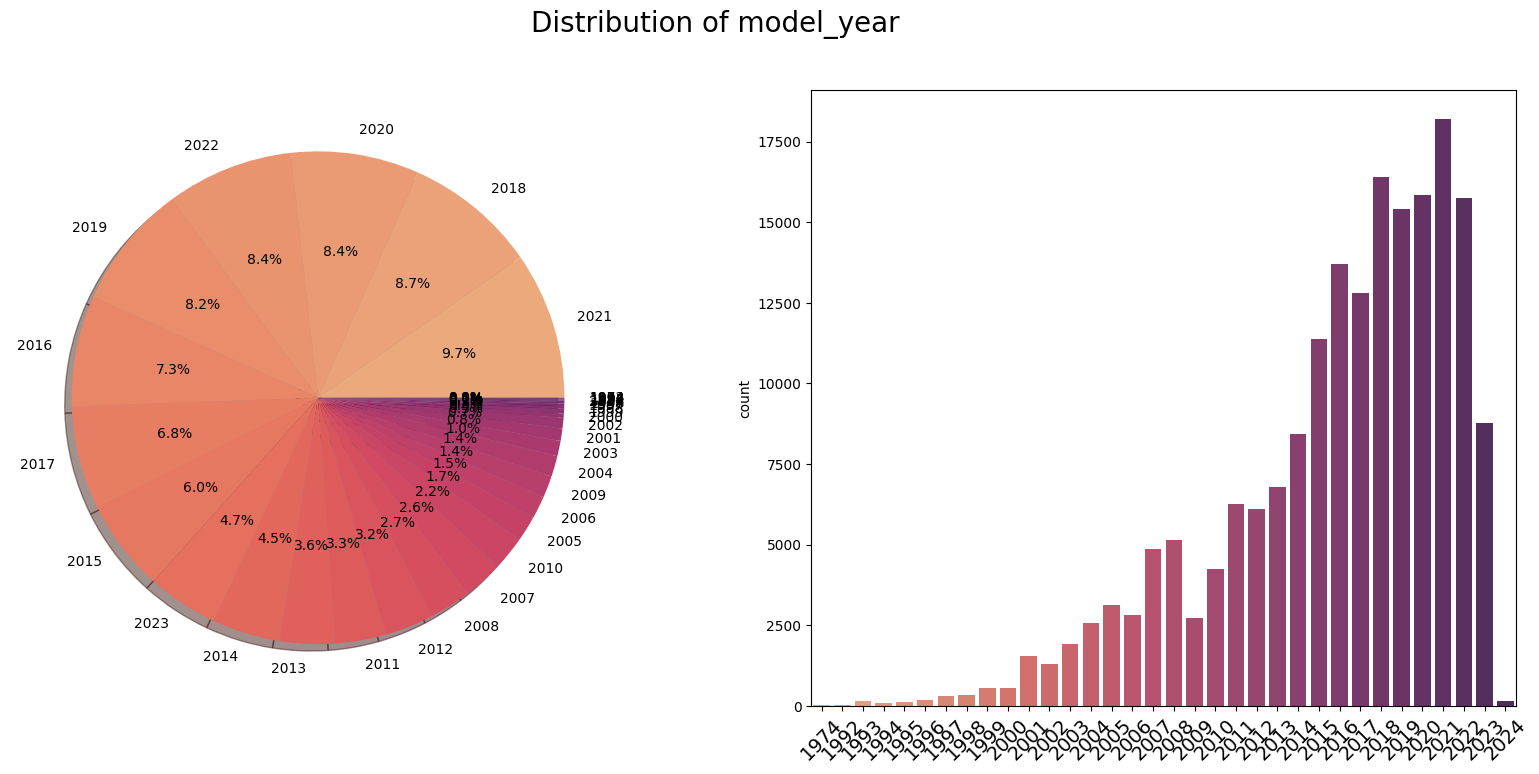

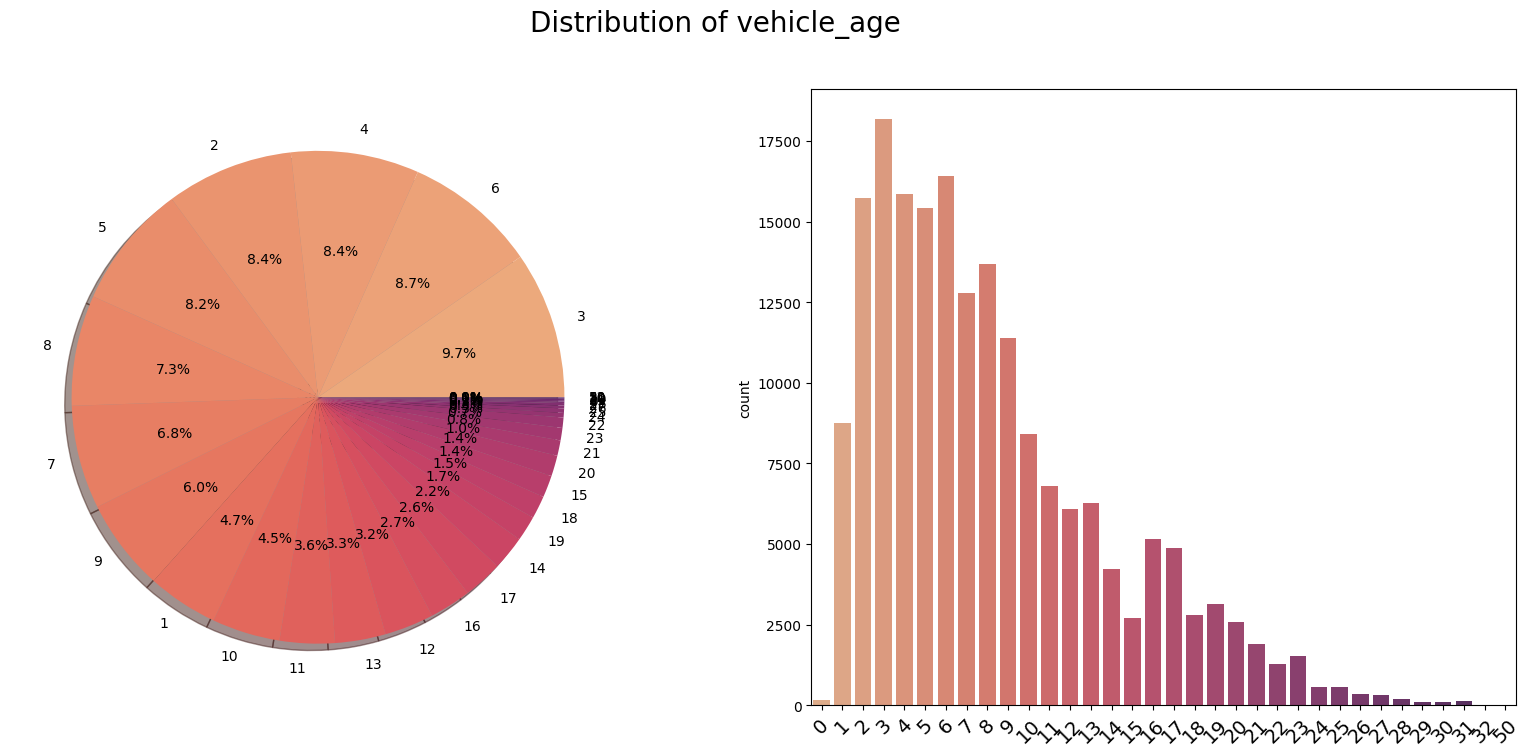

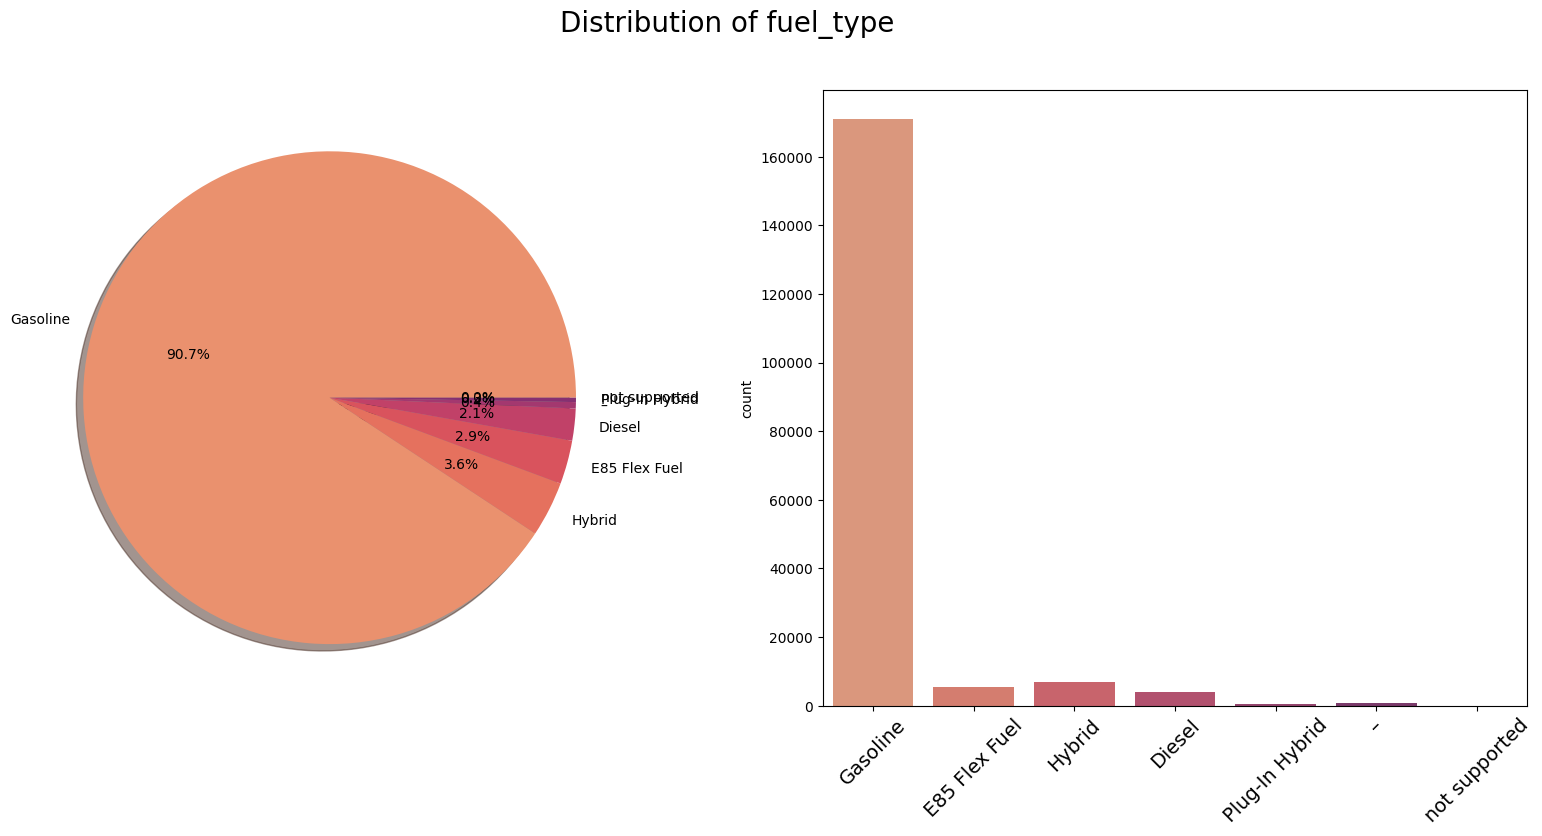

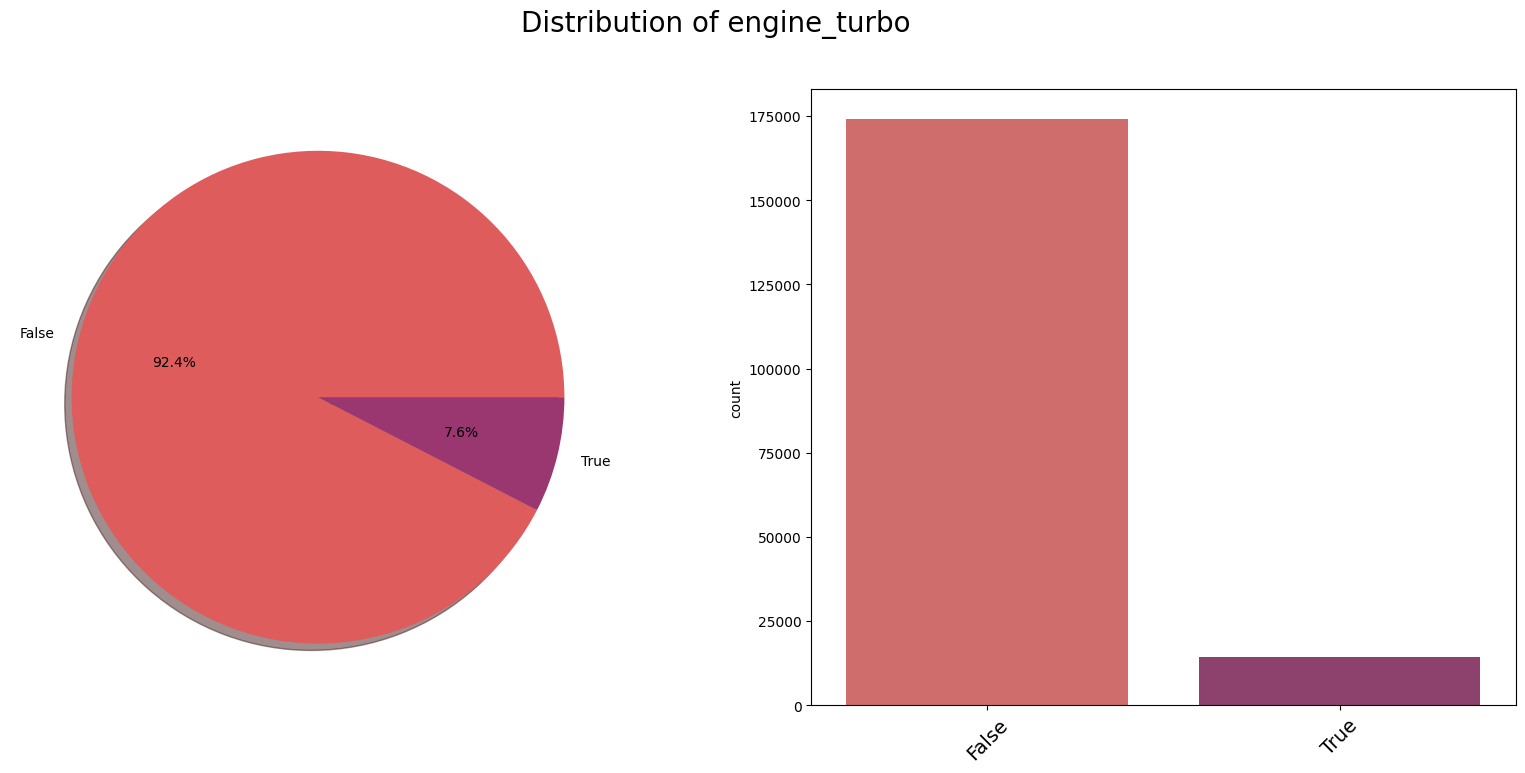

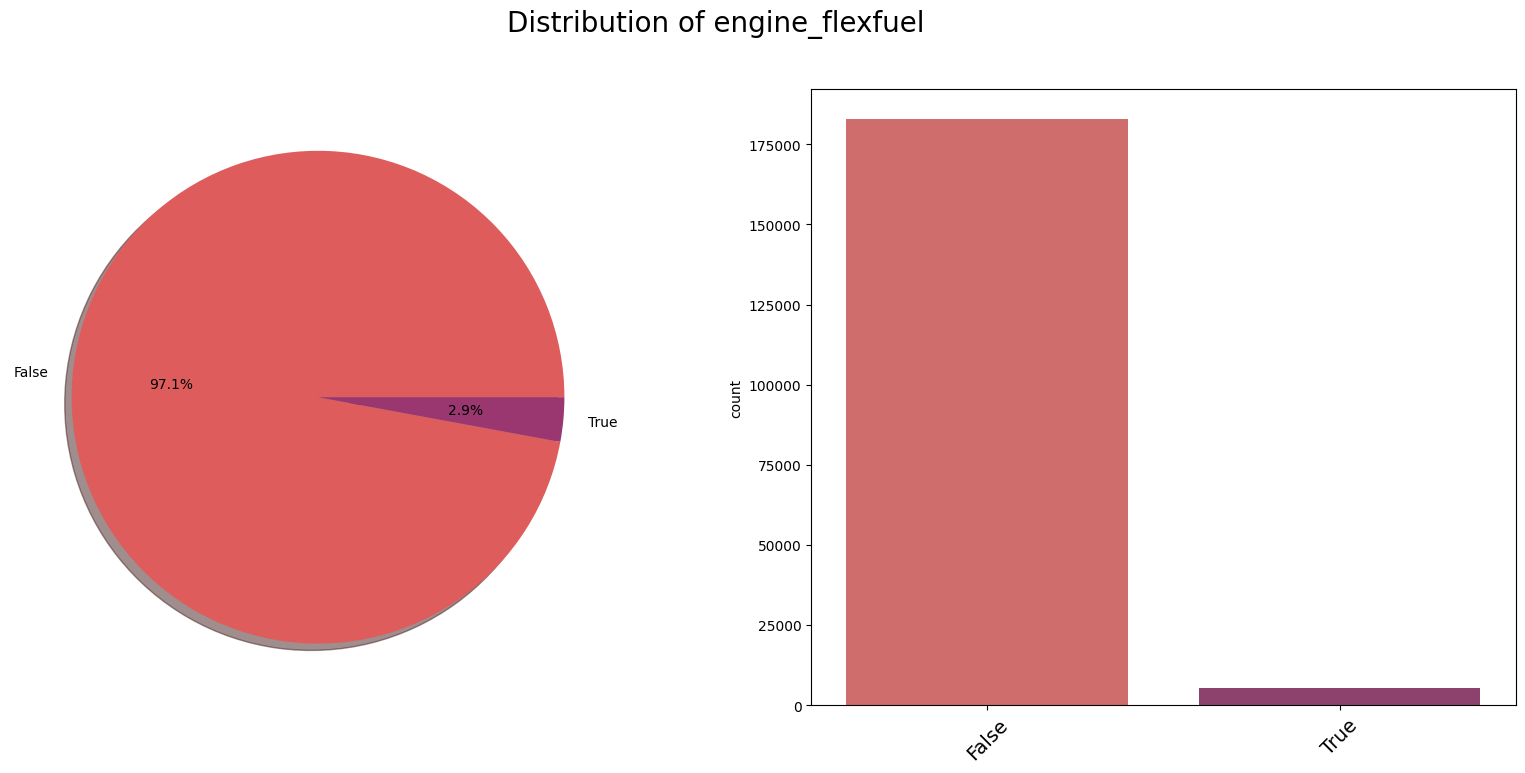

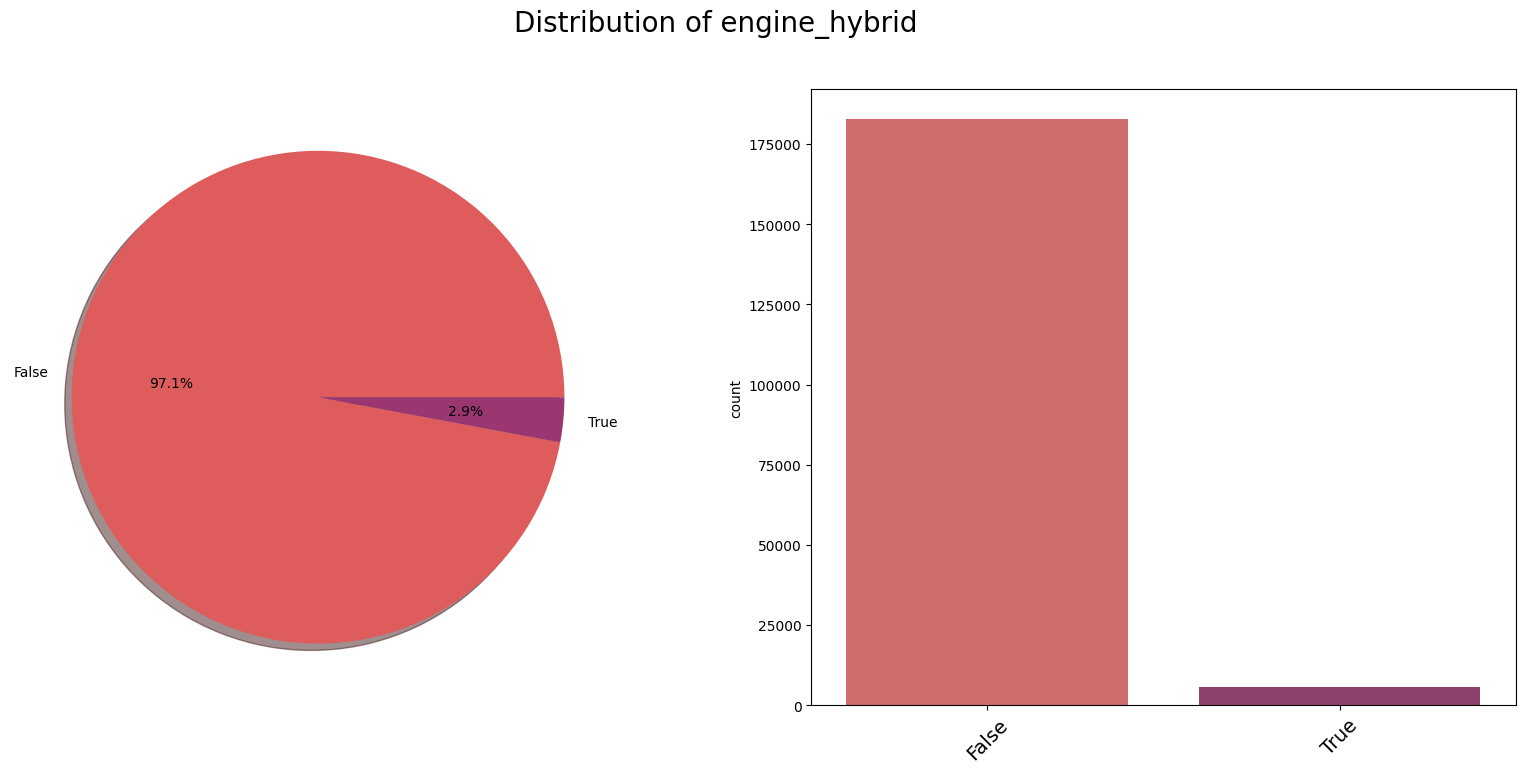

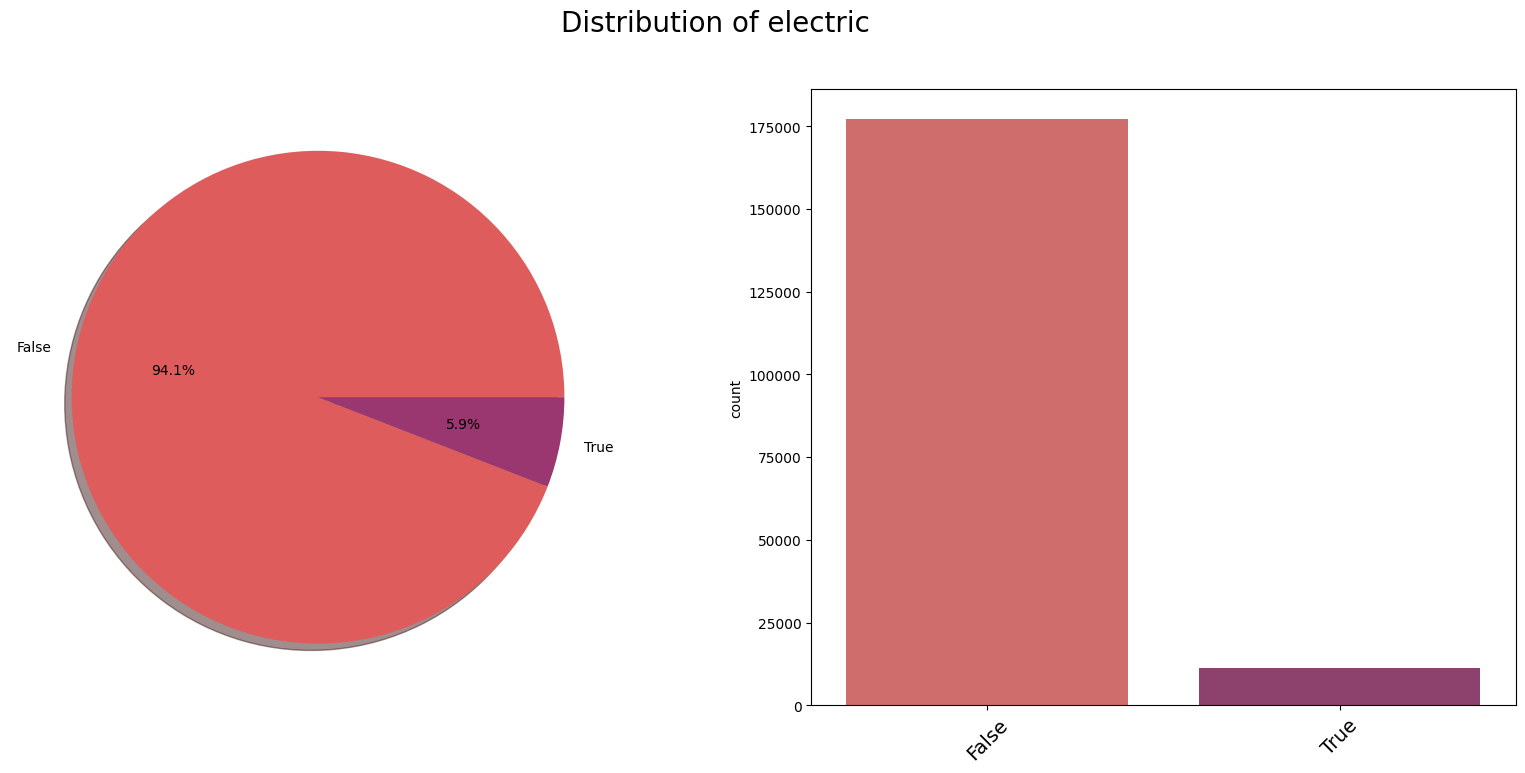

In [20]:
bool_columns = ['engine_turbo', 'engine_flexfuel', 'engine_hybrid', 'electric']
df_train_cleaned[bool_columns] = df_train_cleaned[bool_columns].astype(str)


def generate_colors(n_colors):
    return sns.color_palette("flare", n_colors=n_colors)

def plot_cat_distribution(df, cat_features):

    for column in cat_features:
      
        f, ax = plt.subplots(1, 2, figsize=(20, 8))

        unique_values_count = df[column].nunique()
        colors = generate_colors(unique_values_count)

        
        
        df[column].value_counts().plot.pie(
            autopct='%1.1f%%', 
            ax=ax[0], 
            shadow=True, 
            colors=colors
        )
        ax[0].set_ylabel('')
        ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize=14)
        
        
        
        sns.countplot(
            x=column, 
            data=df, 
            ax=ax[1], 
            palette=colors)
        ax[1].set_xlabel('')
        ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, fontsize=14)

        
        plt.suptitle(f'Distribution of {column}', fontsize=20)
        
        plt.show()
        
        
        
cat_features_eda =  ['accident', 'clean_title', 'model_year', 'vehicle_age', 'fuel_type', 'engine_turbo', 'engine_flexfuel', 'engine_hybrid', 'electric']

plot_cat_distribution(df_train_cleaned, cat_features_eda)

<h1 style="font-size: 20px; border-radius: 20px; padding: 12px; border: 4px solid darkred; line-height: 1.6;">Correlationship | Numerical-Target</h1>

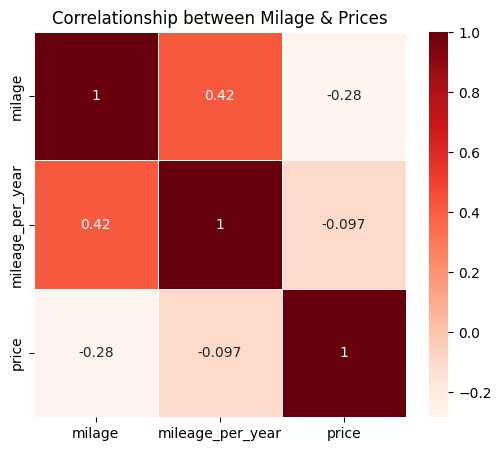

In [21]:
milage_price = ['milage', 'mileage_per_year', 'price']

corr_matrix = df_train_cleaned[milage_price].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='Reds', linewidths=0.5)
plt.title('Correlationship between Milage & Prices')
plt.show()

<h1 style="font-size: 20px; border-radius: 20px; padding: 12px; border: 4px solid darkred; line-height: 1.6;">Correlationship | Categorical-Target</h1>

In [22]:
cat_features = ['model_year', 'clean_title', 'accident', 'model', 'transmission', 'ext_col', 'fuel_type', 'int_col', 'brand']

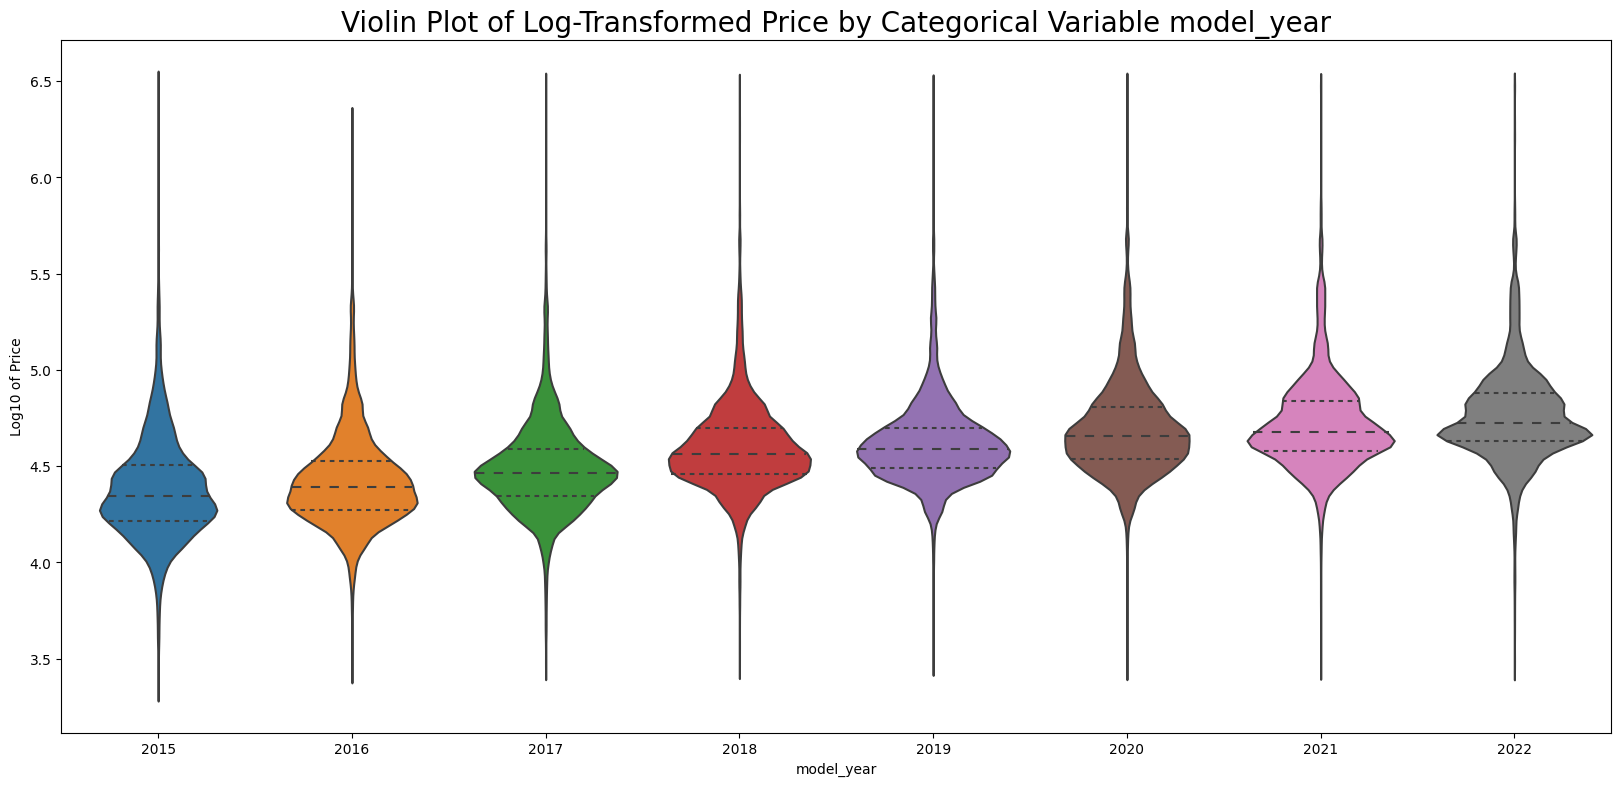

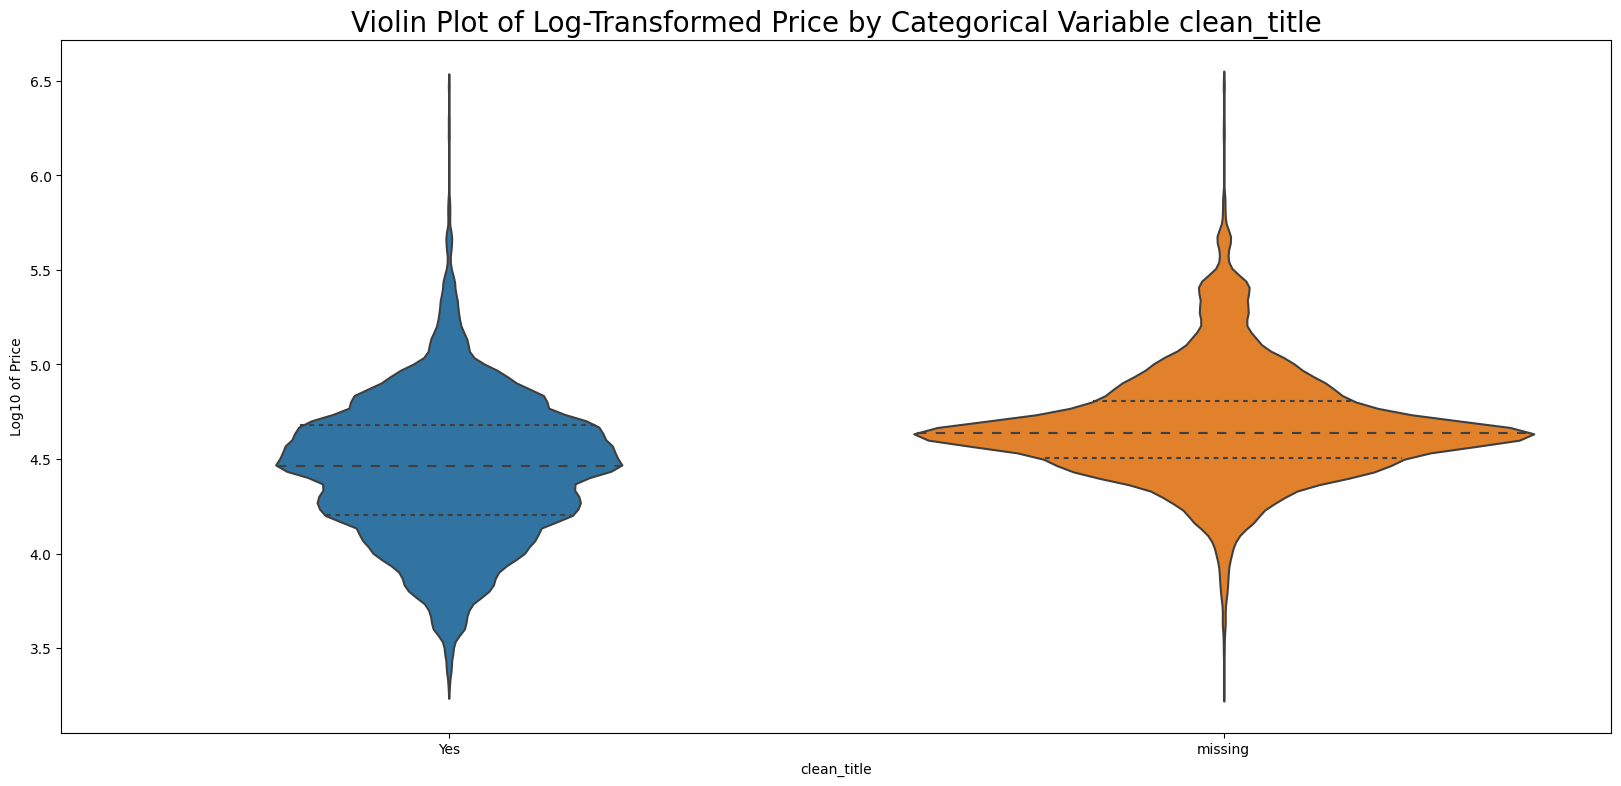

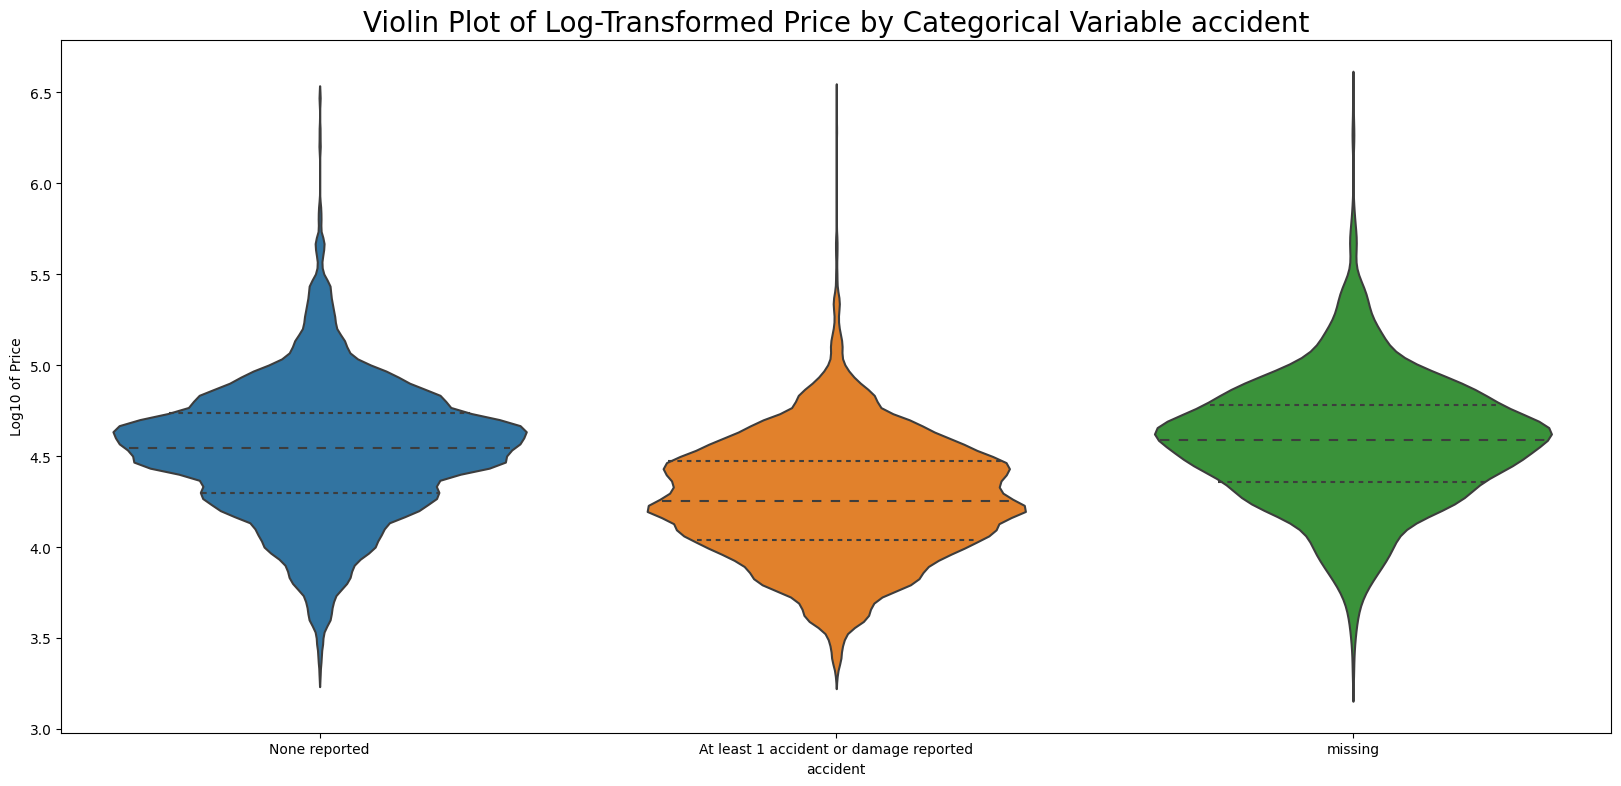

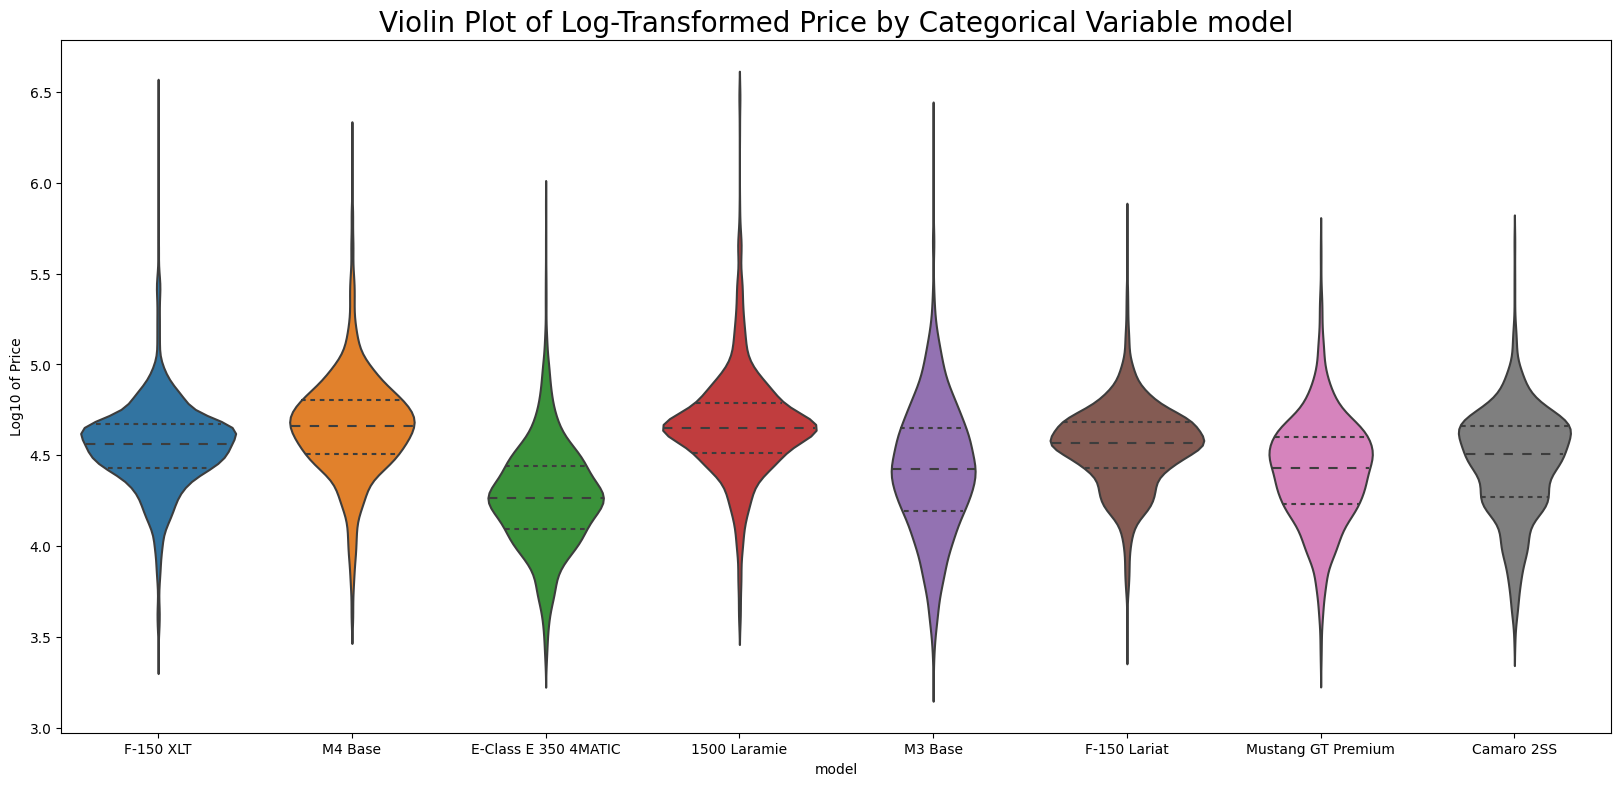

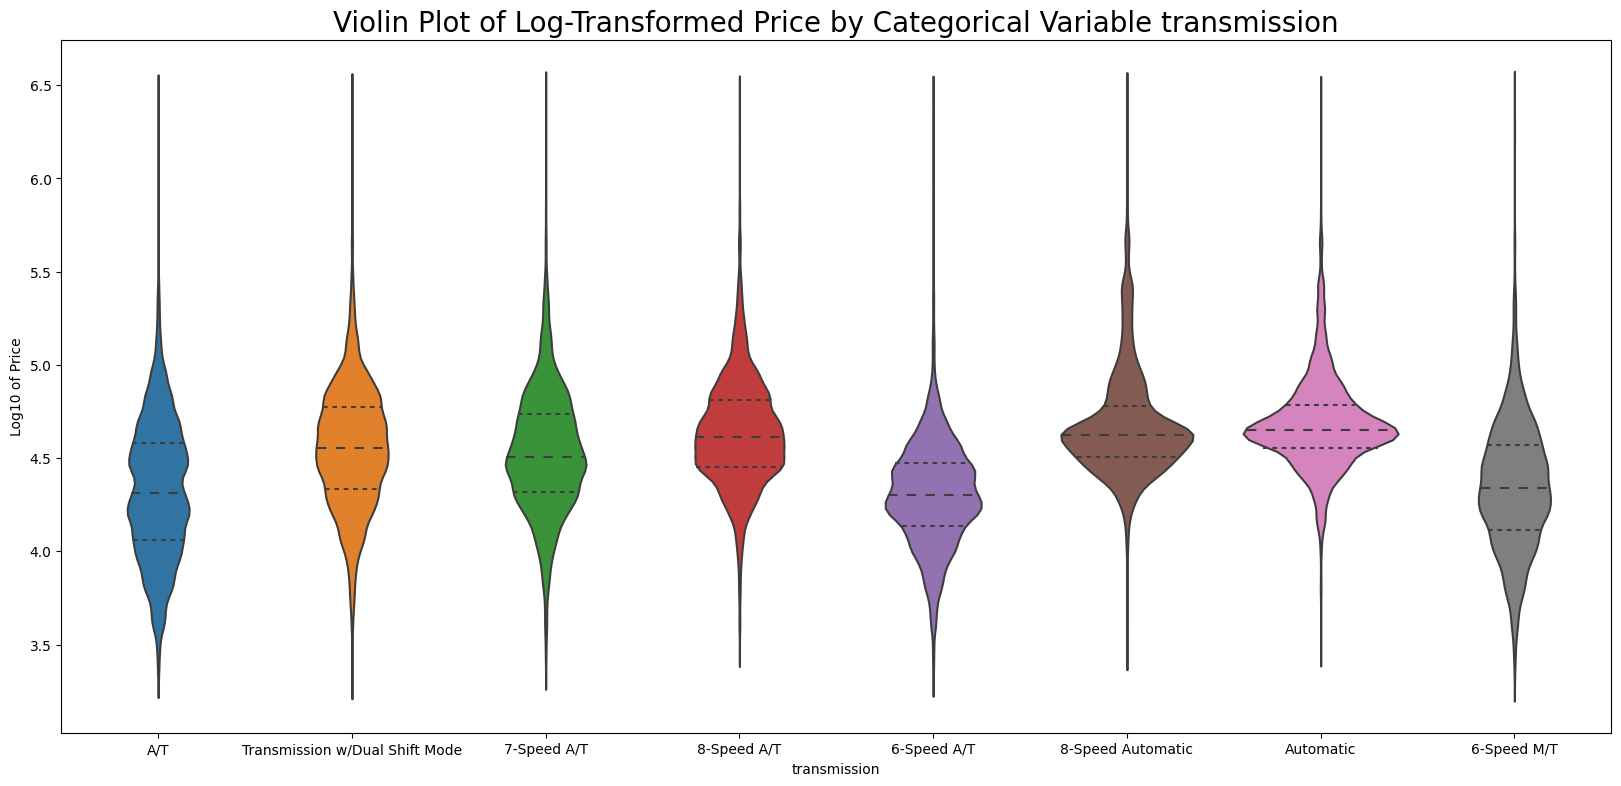

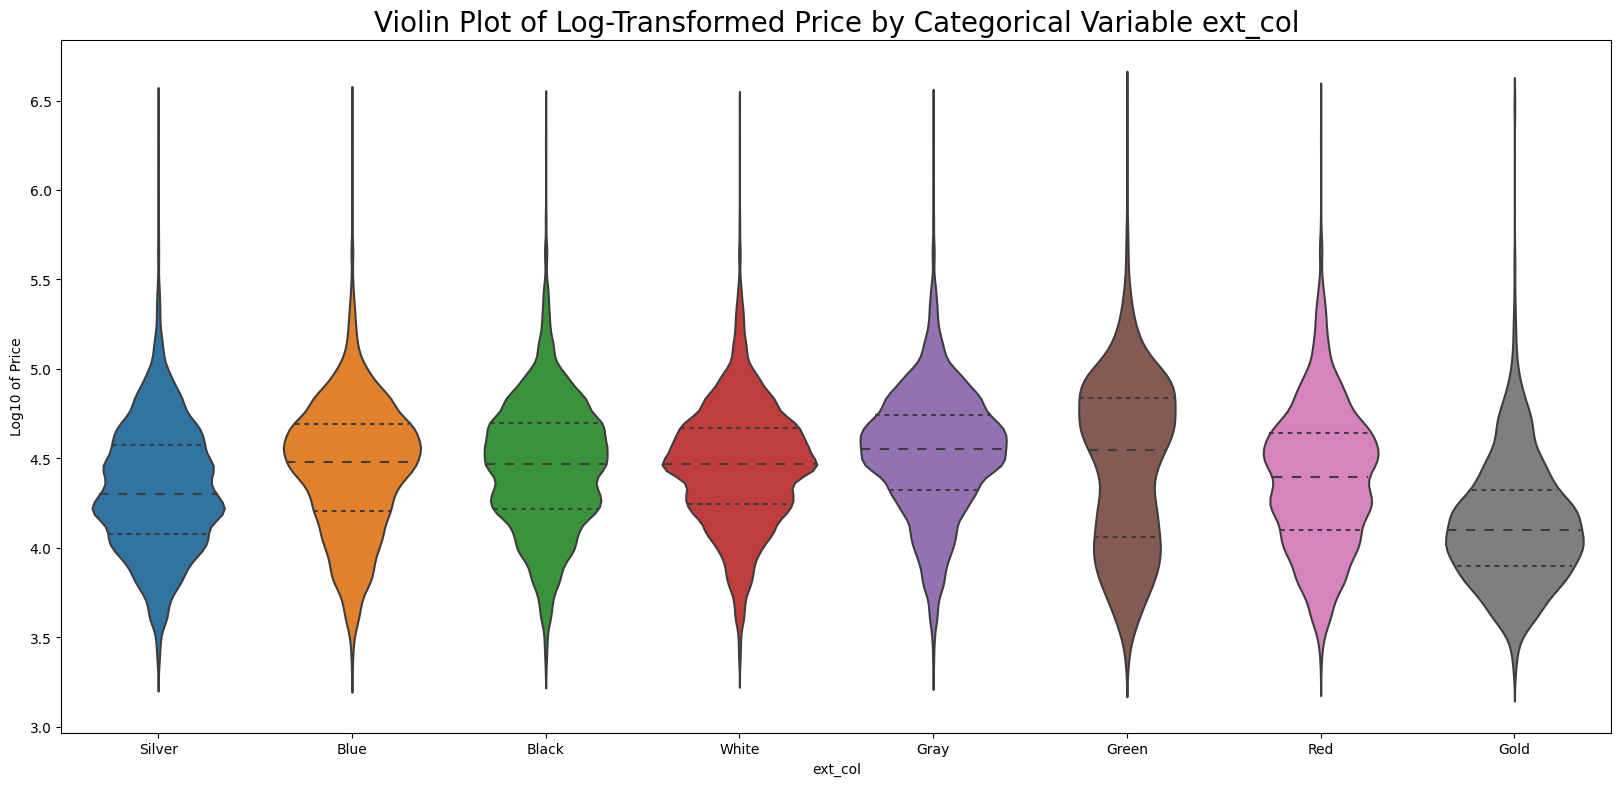

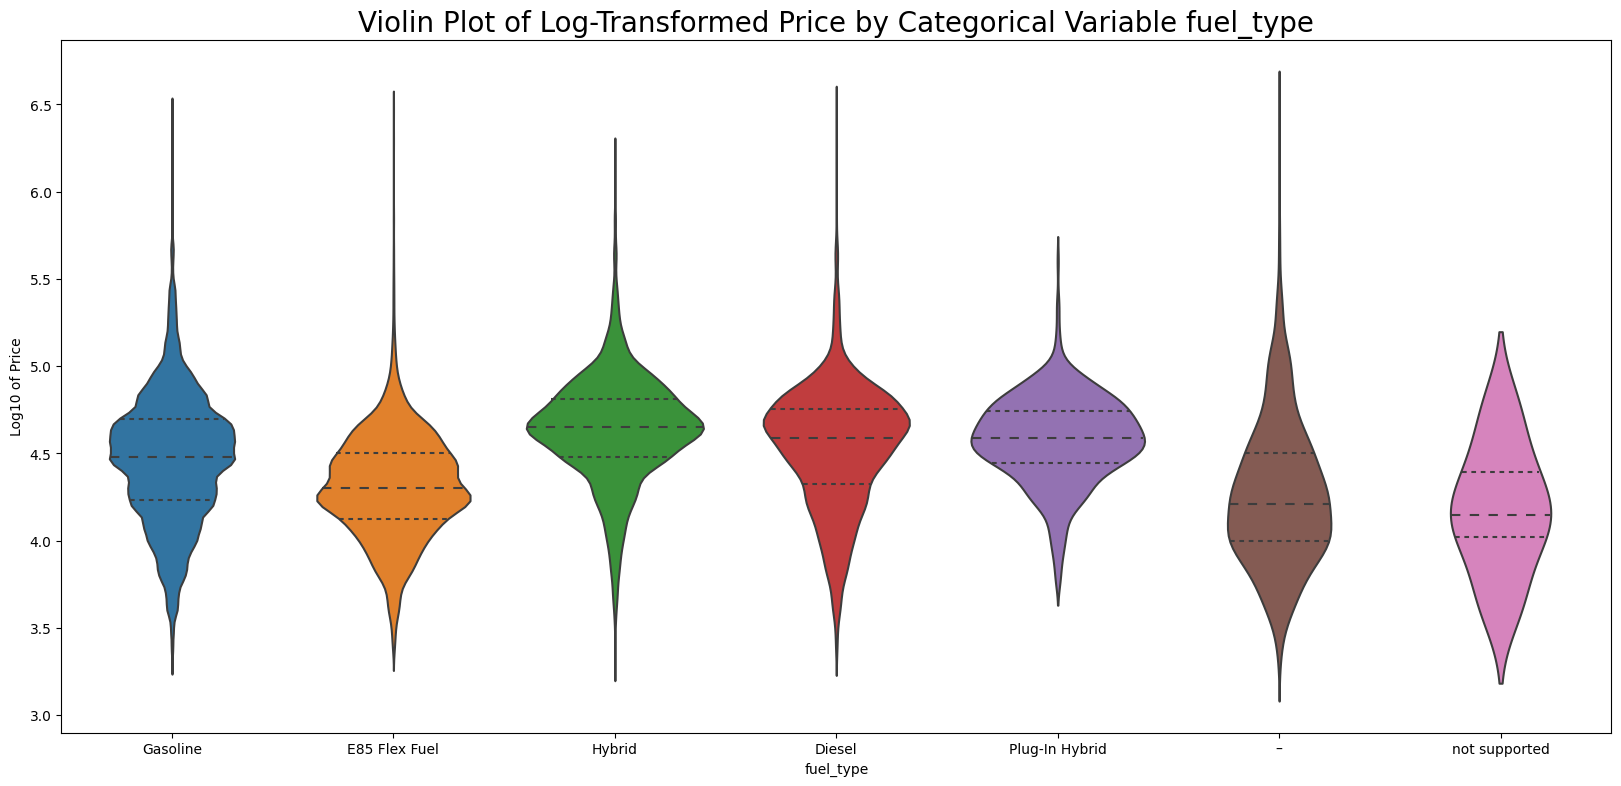

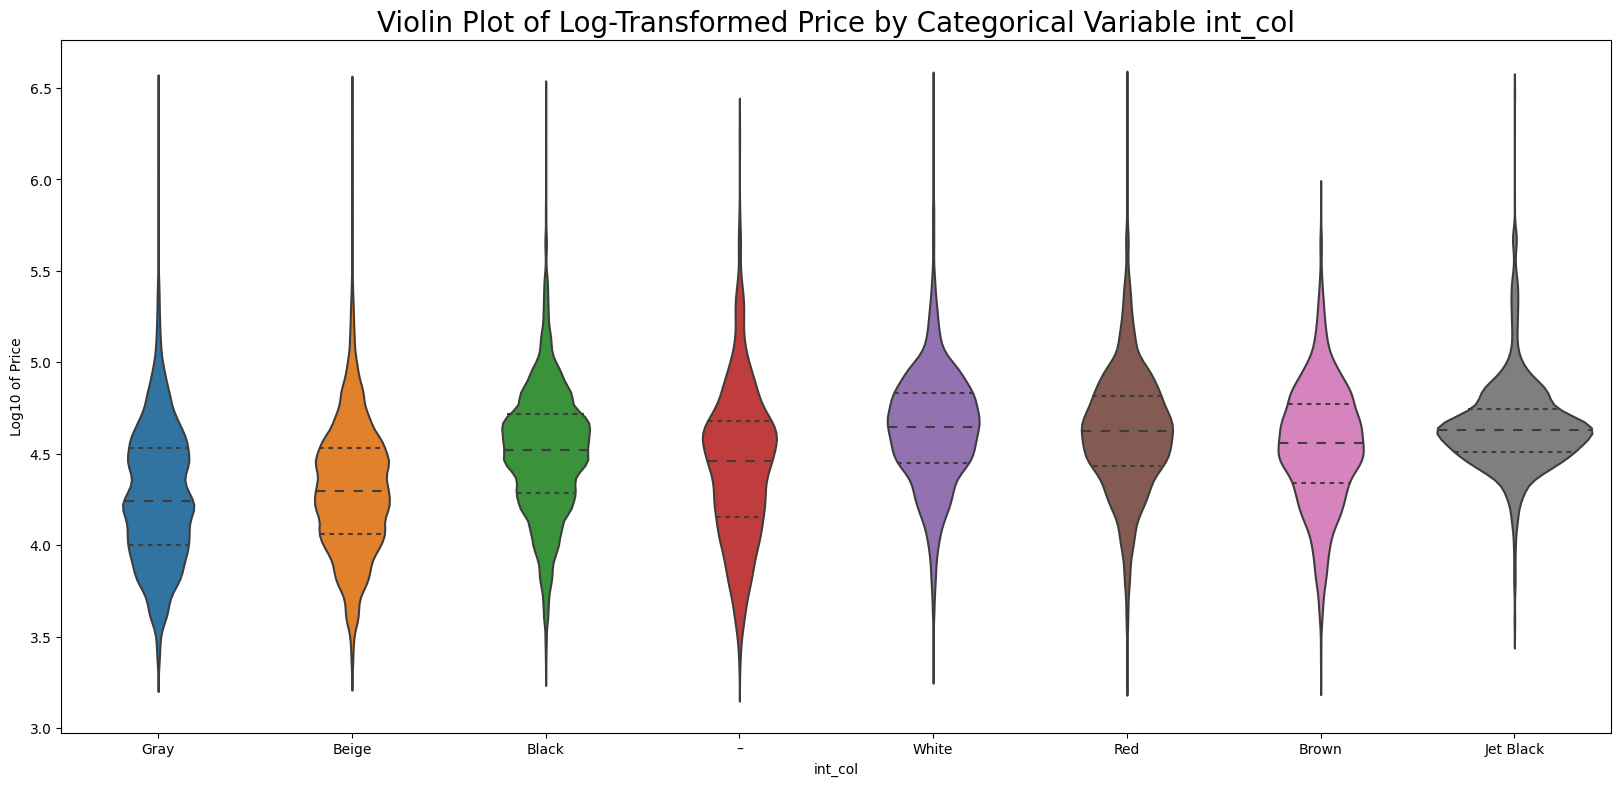

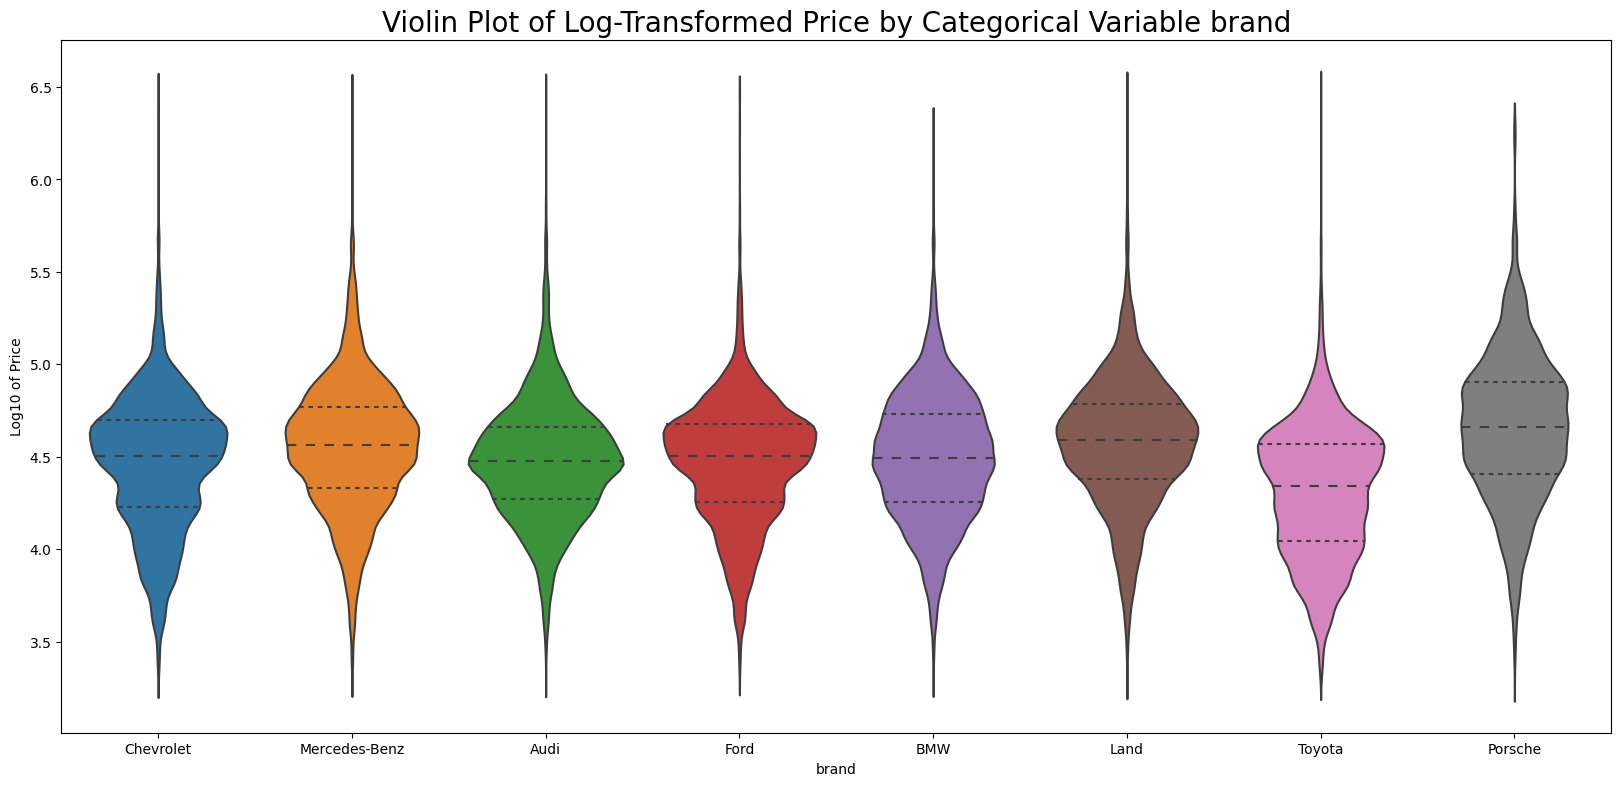

In [23]:
for cat_var in cat_features:

    top_labels = df_train_cleaned[cat_var].value_counts().nlargest(8).index
    
    filtered_data = df_train_cleaned[df_train_cleaned[cat_var].isin(top_labels)]
    
    plt.figure(figsize=(20, 9))
    
    sns.violinplot(
        x=cat_var, 
        y=np.log10(filtered_data['price']),
        data=filtered_data,
        palette='tab10',
        inner='quartile')
    
    plt.title(f'Violin Plot of Log-Transformed Price by Categorical Variable {cat_var}', fontsize=20)
    plt.xlabel(cat_var)
    plt.ylabel('Log10 of Price')
    
    plt.show()

# 

# 🏛️ LGBM Modeling

In [24]:
X = df_train_cleaned.drop(columns=['price']) 
y = df_train_cleaned['price']

In [25]:
X_lgbm = pd.get_dummies(X,  drop_first = True)

In [26]:
kf_lgbm = KFold(n_splits=5, shuffle=True, random_state=rs)

fold_rmse_scores_lgbm = []

for fold, (train_index, val_index) in enumerate(kf_lgbm.split(X_lgbm)):
    print(f"Fold {fold + 1}")

    X_train, X_val = X_lgbm.iloc[train_index], X_lgbm.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    lgbm_params = {
        'subsample': 1.0, 
        'reg_lambda': 0.021544346900318832, 
        'reg_alpha': 10.0, 
        'num_leaves': 550, 
        'n_estimators': 500, 
        'min_data_in_leaf': 130, 
        'min_child_weight': 0.023000000000000003, 
        'max_depth': 12, 
        'learning_rate': 0.025000000000000005, 
        'feature_fraction': 0.9111111111111111, 
        'colsample_bytree': 1.0, 
        'cat_smooth': 60, 
        'bagging_freq': 9, 
        'bagging_fraction': 0.8333333333333333
    }  
    lgbm_model = lgb.LGBMRegressor(**lgbm_params, random_state=rs, verbose=-1, device="gpu")  
    lgbm_model.fit(X_train, y_train)

    y_hat_lgbm = lgbm_model.predict(X_val)

    rmse_lgbm = np.sqrt(mean_squared_error(y_val, y_hat_lgbm))
    fold_rmse_scores_lgbm.append(rmse_lgbm)
    print(f"Fold {fold + 1} LGBM Model's RMSE: {rmse_lgbm}")
    
print(f"Average LGBM Valid RMSE: {np.mean(fold_rmse_scores_lgbm)}")

Fold 1


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Fold 1 LGBM Model's RMSE: 67961.5322012269
Fold 2
Fold 2 LGBM Model's RMSE: 78906.94496009708
Fold 3
Fold 3 LGBM Model's RMSE: 76016.48989320954
Fold 4
Fold 4 LGBM Model's RMSE: 66499.6456087645
Fold 5
Fold 5 LGBM Model's RMSE: 74031.46392706732
Average LGBM Valid RMSE: 72683.21531807308


# 🐈‍⬛ CATB Modeling


In [27]:
X_catb = X.copy()

In [28]:
cat_features = ['model_year', 'clean_title', 'accident', 'model', 'transmission', 'ext_col', 'fuel_type', 'int_col', 'brand', 'engine_hp', 'engine_cc', 'engine_cyl', 'engine_turbo', 'engine_flexfuel', 'engine_hybrid', 'electric'] 

In [29]:
X_catb[cat_features] = X_catb[cat_features].astype(str)

In [30]:
kf_catb = KFold(n_splits=5, shuffle=True, random_state=rs)

fold_rmse_scores_catb = []

for fold, (train_index, val_index) in enumerate(kf_catb.split(X_catb)):
    print(f"Fold {fold + 1}")

    X_train, X_val = X_catb.iloc[train_index], X_catb.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    catb_params = {'learning_rate': 0.01, 
                  'l2_leaf_reg': 7, 
                  'iterations': 1000, 
                  'depth': 12, 
                  'bagging_temperature': 0.7}
    
    catb_model = CatBoostRegressor(**catb_params, cat_features=cat_features, random_state=rs, verbose=500, task_type="GPU")  
    catb_model.fit(X_train, y_train)

    y_hat_catb = catb_model.predict(X_val)

    rmse_catb = np.sqrt(mean_squared_error(y_val, y_hat_catb))
    fold_rmse_scores_catb.append(rmse_catb)
    print(f"Fold {fold + 1} CATB Model's RMSE: {rmse_catb}")
    
print(f"Average CATB Valid RMSE: {np.mean(fold_rmse_scores_catb)}")

Fold 1
0:	learn: 79749.7254722	total: 6.03s	remaining: 1h 40m 19s
500:	learn: 72086.7162263	total: 47.3s	remaining: 47.1s
999:	learn: 70987.7114006	total: 1m 25s	remaining: 0us
Fold 1 CATB Model's RMSE: 67964.74801547424
Fold 2
0:	learn: 77272.5447304	total: 90.1ms	remaining: 1m 29s
500:	learn: 68942.0546165	total: 42.2s	remaining: 42s
999:	learn: 67844.3693569	total: 1m 21s	remaining: 0us
Fold 2 CATB Model's RMSE: 78851.5798561633
Fold 3
0:	learn: 77980.8258719	total: 86.9ms	remaining: 1m 26s
500:	learn: 69727.4302281	total: 42.5s	remaining: 42.3s
999:	learn: 68561.5596900	total: 1m 22s	remaining: 0us
Fold 3 CATB Model's RMSE: 76092.89038416429
Fold 4
0:	learn: 80135.9146998	total: 89.6ms	remaining: 1m 29s
500:	learn: 72489.4574984	total: 42s	remaining: 41.8s
999:	learn: 71555.0306227	total: 1m 20s	remaining: 0us
Fold 4 CATB Model's RMSE: 66344.42180292358
Fold 5
0:	learn: 78420.2924498	total: 86.5ms	remaining: 1m 26s
500:	learn: 70720.8484199	total: 41.8s	remaining: 41.6s
999:	learn:

# 

# 🕸️ Ensemble

In [31]:
X_lgbm_test = pd.get_dummies(df_test_cleaned,  drop_first = True)
X, X_lgbm_test = X_lgbm.align(X_lgbm_test, join='left', axis=1, fill_value=0)
X_catb_test = df_test_cleaned
X_catb_test[cat_features] = X_catb_test[cat_features].astype(str)

In [32]:
lgbm_preds = lgbm_model.predict(X_lgbm_test)
catb_preds = catb_model.predict(X_catb_test)

In [33]:
ensemble_preds = (lgbm_preds + catb_preds) / 2

# 

# 📂 Prediction & Submission

In [34]:
y_pred = ensemble_preds
print(y_pred)

[16831.52051772 77350.42250611 56380.88090057 ... 18881.84648559
 15106.2892924  42804.31660636]


In [35]:
submission = pd.DataFrame({
    'id': df_sub['id'], 
    'price': y_pred  
})
submission.to_csv('submission.csv', index=False)

In [36]:
sub = pd.read_csv('submission.csv')
sub.head()

id         price
0  188533  16831.520518
1  188534  77350.422506
2  188535  56380.880901
3  188536  27388.291535
4  188537  29850.775503

# 

# 💡 Insights from our Data

By reviewing my notebook, the following insights can be drawn:
<br>
1. Missing values are observed in 'clean_title' (11.4%), 'accident' (1.3%), and 'fuel_type' (2.7%). <br>
2. Considering that some sellers may try to hide defects and sell at a higher price, it can be inferred that the missing values in 'clean_title' and 'accident' might be due to intentional non-disclosure by sellers, while the missing values in 'fuel_type' could be due to data entry errors. <br>
3. Therefore when creating used car price forecasting models, separate 'missing' labels will be assigned for 'clean_title' and 'accident.' Meanwhile, the 'fuel_type' will be filled with gasoline, as gasoline is the overwhelming mode at 88%, compared to hybrid (3.6%) and E85 Flex Fuel (2.9%). <br>
4. Analyzing the heatmap between the numerical variable 'mileage' and the target variable 'price' shows that these two variables have a low correlation. Since all features significantly influence the price, the correlation between any single feature and the price might be low. <br>
5. However examining the distribution of categorical variables for the target variable 'price' reveals that used car prices vary unevenly across models, engines, and fuel types. In contrast, other variables show a more consistent distribution for 'price.' <br>
6. Notably 'models' and 'engine' suggest that the prices of certain models and engines are significantly higher than others, potentially indicating the influence of supercars or vintage cars. <br>
7. In the 'fuel_type' category, some gasoline cars tend to sell at relatively high prices, though this trend isn't observed for hybrid cars.